In [1]:
# divide by total counts for that condition OR divide by signal for histone 
# Impute the missing values using sklearn KNN imputer or IterativeImputer or MissForest
# +/- SERFF
# +/- Batch correction 
# assess pipeline using changes between control/DFO volcano and by clustering appearance 

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import re
import math
import statsmodels
import statistics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import mannwhitneyu
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
import os
import seaborn as sns
import umap 
from sklearn.preprocessing import StandardScaler
import gseapy as gp

In [4]:
# functions 
# filter protein features and keep proteins less than 600 missing values,protein features as index 

def filter_row_missings(df,number):
    '''filter protein features and keep proteins less than "number" missing values,protein features as index '''
    
    df_filtered = df[df.isna().sum(axis=1) < number]
    #df_filter = df[df.apply(lambda row: (row == 0).sum(), axis=1) <= 600]
    return(df_filtered)

def filter_column_missings(df,value):
    '''filter samples and keep samples more than "value" protein identifications,samples as columns'''
    df_filtered  = df[df.isna().sum(axis=0) < number]
    return(df_filtered )

# plot histgram of the quantified proteins in all files 
def histgram_nonzero(df): 
    '''should consider Nan values in the dataframe'''
    count_per_column = df.apply(lambda row: (row != 0).sum(), axis=0)
#     non_nan_counts = df.notna().sum()
    plt.figure(figsize=(7.5,5.5))
    plt.rcParams['font.family'] = 'Arial'
    plt.hist(count_per_column, bins=12,edgecolor='#112A46', color='#366AA2', alpha=0.9)
    # Set the font size for individual elements
#     plt.title('Proteome depth', fontsize=16)
    plt.xlabel('Quantified proteins', fontsize=26)
    plt.ylabel('number of samples', fontsize=26)
    plt.xticks([800,1000,1200],fontsize=30)
    plt.yticks([40, 80, 120],fontsize=30)
    plt.savefig(f'{figure_save_path}/histgram_quantified_proteins.svg',dpi=1000,bbox_inches='tight')
    
    plt.show()


# raw quantification file imported and well names replaced 

In [6]:
# row quantification file imported
df_pro = pd.read_csv(r'F:/SMAD PROJECT/new_druganalysis/commonProteins2.csv',index_col=0)
# replace well names with drug names
df_drugname = pd.read_excel(r'F:/SMAD PROJECT/new_druganalysis/drugs0506.xlsx', sheet_name = 'Sheet2')
df_rename = df_pro.T 
# df_pro = pd.read_csv(r'C:/Users/jiangy5/Box/SMAD PROJECT/druganalysis/commonProteins_0518.csv',index_col=0)
drug_function = pd.read_excel(r'F:/SMAD PROJECT/new_druganalysis/drugs0506.xlsx', sheet_name = 'Sheet6')
# tic = pd.read_csv(r'C:\Users\jiangy5\Box\SMAD PROJECT\new_druganalysis\proteome\all_pro_tic.csv',index_col = 0)

In [6]:
# tic1 = tic.loc[:, ~tic.columns.str.contains('QC')]

# tic_columns = []
# for item in tic1.columns:   
#     parts = item.split('_')
#     tic_columns .append(f"{parts[1]}_{parts[0]}")
# tic1.columns = tic_columns 
# tic1.loc['sum_tic'] = tic1.sum()

# save path

In [7]:
figure_save_path = r'F:\SMAD PROJECT\new_druganalysis\proteome\real_result\figures'
file_save_path = r'F:\SMAD PROJECT\new_druganalysis\proteome\real_result\files'

In [8]:
# rename column names from fullpath to well names
new_columns = []
for item in df_rename.columns:   
    hei = item.split('file_')[1].split('_correct')[0].split('_')
    new_columns.append(hei[-1]+'_'+ hei[0])
df_rename.columns = new_columns

In [9]:
# filter the QCs out
df1 = df_rename.loc[:, ~df_rename.columns.str.contains('QC')]
# df1

In [10]:
# rename well names to drug names

dictionary1 = pd.Series(df_drugname['drugnames'].values, index=df_drugname['wells']).to_dict()

dictname = dictionary1
for old, new in dictname.items():
    df1.columns = [colname.replace(old, new) for colname in df1.columns]
    # tic1.columns = [colname.replace(old, new) for colname in tic1.columns]
print(df1.shape)   

(2572, 576)


In [11]:
def select_by_index(df, index_name="HBD"):
    """
    Input a DataFrame and select a subset by index names.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    index_name (str): The string to filter index names by.

    Returns:
    pd.DataFrame: A DataFrame containing rows where the index contains the specified name.
    """
    return df[df.index.str.contains(index_name)]
def select_by_columns(df, column_contains = None):
    """
    Input a DataFrame and select columns based on partial or exact matches.
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    column_contains (str, optional): Substring to match in column names.
    Returns:
    pd.DataFrame: A DataFrame containing only the selected columns.
    """
    if column_contains:
        # Select columns containing the substring
        matching_columns = [col for col in df.columns if column_contains in col]
    if not matching_columns:
        raise ValueError("No matching columns found in the DataFrame.")
    return df[matching_columns]

In [12]:
# df1.to_csv(f'{file_save_path}/proteome_raw_drugnames_replaced.csv')

#  check dataset quality according to quantified proteins 

In [13]:
count_per_column = df1.iloc[2:,:].apply(lambda row: (row != 0).sum(), axis=0)

# Maximum value
max_value = max(count_per_column)
# Minimum value
min_value = min(count_per_column)
# Median value
median_value = statistics.median(count_per_column)
# Mean value
mean_value = statistics.mean(count_per_column)
print(f"Max: {max_value}")
print(f"Min: {min_value}")
print(f"Median: {median_value}")
print(f"Mean: {mean_value}")

Max: 1333
Min: 788
Median: 1061.0
Mean: 1065.2465277777778


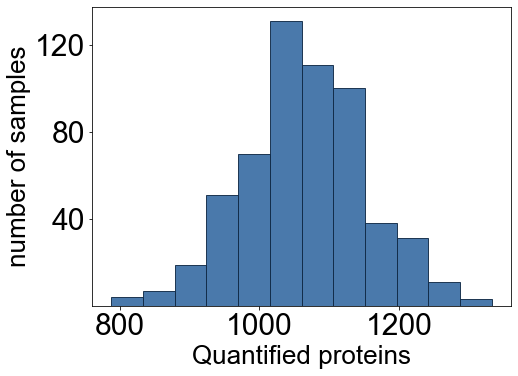

In [14]:
histgram_nonzero(df1.iloc[2:,:])   # plot histgram of quantified proteins 

# dataset cleaning 

In [15]:
# To have protein features exist in at least half samples 
df2 = filter_row_missings(df1.replace(0,np.nan),df1.shape[1]/2)  
# df2 = filter_row_missings(df1.replace(0,np.nan),df1.shape[1]/2).iloc[2:,:]  
print(df2.shape)
# after cleaning 887 protein features left

(1012, 576)


In [16]:
# jio = df2[df2.index.str.contains("NACP")]
# jio.isnull().values.any()

In [17]:
# df2 = df2.replace(np.nan,5000)

# Data preprocessing and normalization

In [18]:
# df2.filter(regex='quality_con', axis=1)

# df_drug = df2.loc[:, ~df2.columns.str.contains('quality_con')]


In [19]:
def get_highest_value_with_index(df):
    result = {}
    for col in df.columns:
        max_value = df[col].max()
        max_index = df[col].idxmax()
        result[col] = (max_index, max_value)
    return result

In [20]:
def knn_imputer(df, neighbors = 6):
    '''apply KNN imputation to a dataset'''
    from sklearn.impute import KNNImputer

    # Initialize the KNNImputer
    imputer = KNNImputer(n_neighbors = neighbors)
    
    imputed_df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns, index=df.index)
    return imputed_df

def iterative_imputer(df, maxiteration = 10 , randomstates = 0):
    from sklearn.experimental import enable_iterative_imputer
    from sklearn.impute import IterativeImputer

    # Initialize the IterativeImputer
    imputer = IterativeImputer(max_iter= maxiteration, random_state= randomstates)

    # Create a new DataFrame with the imputed values
    imputed_df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns, index=df.index)
    return imputed_df

def meanvalue_imputer(df, replicates = 6):
    # impute missing values with Mean, imput dataframe should be sorted by index ot group replicates together
    
    chunks = []
    total_rows = df.shape[0]
    num_chunks = total_rows // replicates  # Calculates how many full chunks of size nu there are

    # Loop through the DataFrame in chunks
    for i in range(0, total_rows, replicates):
        # Create a chunk by slicing the DataFrame
        chunk = tar_df.iloc[i:i + replicates, :]

        # Apply the fillna operation using the mean of each column
        filled_chunk = chunk.apply(lambda x: x.fillna(x.mean()), axis=0)

        # Append the processed chunk to the list
        chunks.append(filled_chunk)

    # Concatenate all chunks back into a single DataFrame
    imputed_df = pd.concat(chunks)
    return imputed_df

class DatasetNormalizeDf:
    
    @staticmethod 
    def divided_by_a_protein(df, row_index = '2/sp|Q16777|H2A2C_HUMAN/sp|Q6FI13|H2A2A_HUMAN'):
        '''Divides the DataFrame by a specific protein row index,
        columns as treatments and rows as proteins'''
        
        # Dividing the entire DataFrame by the chosen row
        normalized_df = df.div(df.loc[row_index], axis=1)
                               
        return normalized_df  
    
    @staticmethod      
    def divided_by_total_counts(df):
        '''Divides each column in the DataFrame by the total sum of that column,
        columns as treatments and rows as proteins'''
               
        column_sums = df.sum()
        normalized_df = df.div(column_sums, axis=1)
        
        return normalized_df
    
    def standardscaler(df):     
        '''apply standard normalization to a dataframe, 
        columns as treatments and rows as proteins'''
        # # Initialize the StandardScaler
        scaler = StandardScaler()
        # Fit and transform the data according to rows
        scaled_data = scaler.fit_transform(df)
        normalized_df = pd.DataFrame(scaled_data, index=df.index, columns=df.columns)
        return normalized_df

def get_dmso_dfo(df):
    dmso = df.filter(regex='DMSO', axis=1)
    dfo = df.filter(regex='DFO', axis=1)
    return (dmso,dfo)        

In [21]:
# Function to determine label
def get_label(index):
    for name in namestrings:
        if name in index:
            return name
    return 'Others'

# function to plot UMAP according to 

def plot_umap(df, namestring = ['1'], figuretitle = 'UMAP'):
    plt.rcParams['font.family'] = 'Arial'
    reducer = umap.UMAP(n_neighbors=15, n_components=2, random_state=42)
    scaler = StandardScaler()
    # Fit and transform the data according to rows
    df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
    embedding = reducer.fit_transform(df_scaled)   
    # Step 3: Create a new DataFrame for UMAP results
    umap_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'], index=df.index)
    
    # Step 4: Add non-numeric labels to the new DataFrame
#     umap_df['Label'] = df.index.map(lambda x: namestring1 if namestring1 in x else
#                                               namestring2 if namestring2 in x else
#                                               namestring3 if namestring3 in x else 'others')
    umap_df['Label'] = df.index.map(get_label)
    # Define a custom color palette for the labels
    color_dict = {
        'label1': 'red',
        'label2': 'blue',
        'label3': 'green',
        'others': 'grey'
    }
    # Step 5: Plot using the new DataFrame
    #palette = {namestring: 'red', 'others': 'grey'}
    #palette = color_dict
    plt.figure(figsize=(5.5, 4.5))
    sns.scatterplot(x='UMAP1', y='UMAP2', hue='Label', data=umap_df, s=60, alpha=0.8, legend=True,palette=color_dict)
    plt.title(figuretitle,fontsize=18)
    plt.xlabel('UMAP 1',fontsize=20)
    plt.ylabel('UMAP 2',fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1),fontsize=16)
    # plt.savefig(f'{figure_save_path}/{figuretitle}.svg',dpi=800,bbox_inches='tight')
    plt.show()

In [19]:
# df2.filter(regex='H2AV_HUMAN', axis=0).T.info()

In [20]:
# df3 = knn_imputer(df2, neighbors = 3)
# df3.to_csv(f'{file_save_path}/proteome_after_Normalization and imputation.csv')

In [22]:
# df2 = df2.reindex(sorted(df2.columns), axis=1).iloc[2:,:]
df2 = df2.reindex(sorted(df2.columns), axis=1)

In [23]:
# should we do missing values imputation before normalization or after? 


In [24]:
df3 = knn_imputer(df2, neighbors = 4).abs()   # applied neighbors == 6

# df3 = knn_imputer(normalized_df, neighbors = 4).abs()   

In [25]:
# tic1 = tic1.reindex(sorted(tic1.columns), axis=1)

In [26]:
# normalized_df =df2.div(tic1.loc['sum_tic'], axis=1)*1000000

In [27]:
# normalized_df =DatasetNormalizeDf.standardscaler(df3)

# normalized_df = DatasetNormalizeDf.divided_by_total_counts(np.log2(df3))*10000
normalized_df = DatasetNormalizeDf.divided_by_total_counts(df3)*10000

# # normalized_df2 = DatasetNormalizeDf.standardscaler(normalized_df)
# normalized_df = DatasetNormalizeDf.standardscaler(np.log2(df3))
# # normalized_df = DatasetNormalizeDf.divided_by_a_protein(np.log2(df3), row_index = '2/sp|P0C0S5|H2AZ_HUMAN/sp|Q71UI9|H2AV_HUMAN')*10
# # normalized_df.drop(index='2/sp|P0C0S5|H2AZ_HUMAN/sp|Q71UI9|H2AV_HUMAN', inplace=True)
# normalized_df


In [28]:
# normalized_df.to_csv(f'{file_save_path}/proteome_after_Normalization.csv')

In [29]:
# df3 = knn_imputer(normalized_df, neighbors = 2)
# df3.to_csv(f'{file_save_path}/proteome_after_Normalization and imputation.csv')

In [30]:
# df2.filter(regex='DFO', axis=1).info()

In [31]:
# namestrings = ['1','2','3','4','5','6']
# plot_umap(df3.T, namestring = namestrings, figuretitle = '6 batches')
# namestrings = ['DMSO','DFO']
# namestrings = ['DFO']

In [32]:
# namestrings = ['DMSO','DFO']
# plot_umap(normalized_df.T, namestring = namestrings, figuretitle = 'DMSO_DFO')

In [33]:
# dfx.loc['1/sp|Q9BZK3|NACP4_HUMAN']

#  Batch effect correction 

In [34]:
def combat_correction(result = df3):
    '''input dataframe contains proteins (rows) for each sample (columns)'''
    from combat.pycombat import pycombat
    
#   batchs: List of batch indexes. The batch list describes the batch for each sample. 
    batchs = [int(''.join(re.findall(r'\d+', item))) for item in  result.columns] 

    corrected_df = pycombat(result, batchs)
    # result['batches'] = batchs
    return corrected_df

In [35]:
# df4 = combat_correction(result = df3.drop('2/sp|P0C0S5|H2AZ_HUMAN/sp|Q71UI9|H2AV_HUMAN'))
dfx = combat_correction(result = normalized_df)
# dfx = combat_correction(result = df3)
# dfx.to_csv(f'{file_save_path}/proteome_after_Normalization and imputation and BC.csv')
# df4.to_csv(f'{file_save_path}/proteome_normalization_missing_batch_done.csv')

Found 6 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


In [36]:
# namestrings = ['DMSO']
# plot_umap(dfx.T, namestring = namestrings, figuretitle = 'DMSO_UMAP_proteome')

In [37]:
# namestrings = ['1','2','3','4','5','6']
namestrings = ['DFO']
plot_umap(dfx.T, namestring = namestrings, figuretitle = 'Deferoxamine-UMAP-proteome')

AttributeError: module 'umap' has no attribute 'UMAP'

In [38]:
# sample_df = df4.filter(regex=('DMSO|DFO'), axis=1)
# plot_umap(sample_df.T, namestring = namestrings, figuretitle = 'DMSO_DFO_only')

In [39]:
namestrings = ['1','2','3','4','5','6']
# namestrings = ['DMSO','DFO']
plot_umap(dfx.T, namestring = namestrings, figuretitle = '6 Batches-proteome')

AttributeError: module 'umap' has no attribute 'UMAP'

# check DMSO and DFO

In [40]:
sorted_columns = sorted(dfx.columns)

# Reindex DataFrame with sorted columns
df_sorted = dfx[sorted_columns]
# df_sorted2 = ki[sorted_columns]
# df_sorted.to_csv(f'{file_save_path}/proteome_after_Normalization imputation BC and index rename.csv')

In [41]:
def bh_correction(p_values):
    _, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
    return pvals_corrected

In [42]:
# check before batch correction 
# df = df4*1000
df = df_sorted
dmso = df.filter(regex='DMSO', axis=1)
dfo = df.filter(regex='DFO', axis=1)
drugs = df.loc[:, ~df.columns.str.contains('DMSO|DFO')]
# Function to apply Benjamini-Hochberg correction to a series of p-values

In [43]:

results_dict = {'Protein': [], 'logFC': [], 'FC': [], 'pValue': []}

for j in range(dmso.shape[0]):
    dmsopro = dmso.iloc[j, :].tolist()
    dfopro = dfo.iloc[j, :].tolist()
    protein_name = dmso.index[j]     
    # Calculate the p-value of the t-test between drug and DMSO profiles
    pval = stats.ttest_ind(dfopro, dmsopro, equal_var=False)[1]
    
    # Calculate the log fold change
    logFC = np.log2(np.mean(dfopro) / np.mean(dmsopro))
    # Calculate the fold change
    FC = np.mean(dfopro) / np.mean(dmsopro)
#   logFC = np.mean(dfopro) / np.mean(dmsopro)
    # Store the results
    results_dict['Protein'].append(protein_name)
    results_dict['logFC'].append(logFC)
    results_dict['FC'].append(FC)
    results_dict['pValue'].append(pval)
# change to df    
results_df = pd.DataFrame(results_dict)
results_df.set_index('Protein', inplace = True)

# aapply bh_correction to the p value and add a new column
results_df['bh_corrected_pVal'] = bh_correction(results_df['pValue'])
results_df['-log10(pValue)'] = -np.log10(results_df['bh_corrected_pVal'])

In [44]:
# List of glycolytic proteins (gene names)
# upregulation of glycolysis proteins   DFO 
glycolytic_proteins = ['1/sp|P05091|ALDH2_HUMAN', 
                       '1/sp|P04075|ALDOA_HUMAN',
                       '1/sp|P09622|DLDH_HUMAN',
                       '1/sp|P00558|PGK1_HUMAN',
                       '1/sp|P36871|PGM1_HUMAN',
                       # '1/sp|P08237|PFKAM_HUMAN',
                       '1/sp|P06733|ENOA_HUMAN']

In [45]:
results_df.loc[glycolytic_proteins]

,logFC,FC,pValue,bh_corrected_pVal,-log10(pValue)
Protein,,,,,
1/sp|P05091|ALDH2_HUMAN,0.116882,1.084389,5.609411e-04,1.302015e-03,2.885384
1/sp|P04075|ALDOA_HUMAN,0.037832,1.026570,4.113816e-02,6.504971e-02,1.186755
1/sp|P09622|DLDH_HUMAN,0.161656,1.118571,4.408139e-08,2.299504e-07,6.638366
1/sp|P00558|PGK1_HUMAN,0.093044,1.066619,2.692688e-06,1.052124e-05,4.977933
1/sp|P36871|PGM1_HUMAN,0.063494,1.044994,1.333746e-02,2.335208e-02,1.631674
1/sp|P06733|ENOA_HUMAN,0.092103,1.065923,2.617520e-07,1.198611e-06,5.921322


In [46]:
# df4.loc[glycolytic_proteins]

In [47]:
from adjustText import adjust_text

def plot_volcano(df, mark_list = glycolytic_proteins, 
                 title_name = 'Volcano Plot of Protein Dysregulation (DFO vs DMSO)'):
    '''plot a volcano form a dataframe which contains P value, FC and -log10(pValue) column and protein names as index'''
    # Create the volcano plot
    plt.figure(figsize=(6.3, 6))
    plt.rcParams['font.family'] = 'Arial'
    # Plot the points
    # Plot upregulated proteins (red)
    sns.scatterplot(data=df[df['logFC'] > 0], x='logFC', y='-log10(pValue)', color='#BB0C00', label='Up', s=80)
    # Plot downregulated proteins (green)
    sns.scatterplot(data=df[df['logFC'] < 0], x='logFC', y='-log10(pValue)', color='#00A99F', label='Down', s=80)
    # Plot downregulated proteins (green)
    sns.scatterplot(data=df[df['-log10(pValue)'] < 1.3], x='logFC', y='-log10(pValue)', color='#555758', s=80)
    # Highlight specific glycolytic proteins in black
    highlighted = df.loc[mark_list]
    sns.scatterplot(data=highlighted, x='logFC', y='-log10(pValue)', color='black', s=150)
    # Add title and labels
    # plt.title(title_name, fontsize=14)
    plt.xlabel('Log2 Fold Change', fontsize=22)
    plt.ylabel('-Log10 p-value', fontsize=22)
    # Add threshold lines for significance
    plt.axhline(y=-np.log10(0.05), color='#3B3939', linestyle='--')
    plt.axvline(x=0, color='#3B3939', linestyle='--')
    # plt.axvline(x=-1.0, color='b', linestyle='--')
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)     
    # Collect all the texts to adjust later
    texts = []    
    for protein_name in mark_list:
        if protein_name in df.index:
            row = df.loc[protein_name]
            text = plt.text(row['logFC'], row['-log10(pValue)'] + 1, protein_name.split('|')[-1].split('_')[0], 
                            fontsize=20, ha='right', color="blue")
            texts.append(text)
    
    # Adjust the text labels to prevent overlap
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))
    
    plt.savefig(f'{figure_save_path}/{title_name}.svg',dpi=800,bbox_inches='tight')
    plt.legend(fontsize = 20)
    plt.show()
    
def plot_volcano2(df, mark_list = glycolytic_proteins, label_name = "Lipids"):
    '''plot a volcano form a dataframe which contains P value, FC and -log10(pValue) column and metabolites as index'''
    # Create the volcano plot
    plt.figure(figsize=(6.3, 6))
    # Plot the points
    # Plot upregulated proteins (red)
    sns.scatterplot(data=df[df['logFC'] > 0], x='logFC', y='-log10(pValue)', color='#BB0C00', label='Up', s=20)
    # Plot downregulated proteins (green)
    sns.scatterplot(data=df[df['logFC'] < 0], x='logFC', y='-log10(pValue)', color='#00A99F', label='Down', s=20)
    # Plot downregulated proteins (green)
    sns.scatterplot(data=df[df['-log10(pValue)'] < 1.3], x='logFC', y='-log10(pValue)', color='#555758', s=20)
    
    # Highlight specific glycolytic metabolites in black
    highlighted = df.loc[mark_list]
    sns.scatterplot(data=highlighted, x='logFC', y='-log10(pValue)',label=f'{label_name}', color='blue', s=50)
    # Add title and labels
    plt.title('Volcano Plot of Metabolome Dysregulation (DFO vs DMSO)', fontsize=14)
    plt.xlabel('Log2 Fold Change', fontsize=18)
    plt.ylabel('-Log10 p-value', fontsize=18)
    # Add threshold lines for significance
    plt.axhline(y=-np.log10(0.05), color='#3B3939', linestyle='--')
    plt.axvline(x=0, color='#3B3939', linestyle='--')
    # plt.axvline(x=-1.0, color='b', linestyle='--')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)  
    # Show the plot
    plt.show()    
    

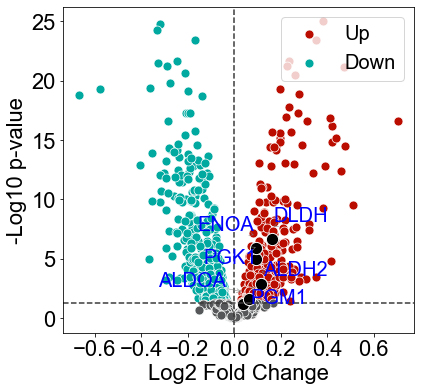

In [48]:
plot_volcano(results_df,title_name = 'Protein Dysregulation (DFO vs DMSO)')

In [49]:
def get_drug_df(protein_name, drug_name):
    
    df_drug_pro = dfx.filter(regex=drug_name, axis=1).loc[protein_name].to_frame()
    df_drug_pro['treatment'] = [drug_name]*len(df_drug_pro)
    return df_drug_pro


def get_full_df(protein_name = '1/sp|P05091|ALDH2_HUMAN',name_list = namestrings):
    
    chunks = []      
    for drug_name in name_list:
        dfdf = get_drug_df(protein_name, drug_name)
        chunks.append(dfdf)
    final_df = pd.concat(chunks)
    return final_df 

def plot_bar_scatter(protein_name = '1/sp|P05091|ALDH2_HUMAN',df= dfx):
    plt.rcParams['font.family'] = 'Arial'
    plt.figure(figsize=(5, 4.5))
    ax = sns.boxplot(x="treatment", y = protein_name,width=0.8, data=df,palette='viridis')
    ax = sns.stripplot(x="treatment", y = protein_name, data=df, color="black",size=12)
    ax.set_xlabel("")
    ax.set_ylabel("Score", fontsize=18)
    ax.tick_params(axis='both', labelsize=18)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
    plt.title(protein_name.split('|')[-1].split('_')[0],fontsize=18)
    savename = protein_name.split('|')[-1]
    plt.savefig(f'{figure_save_path}/{savename}.svg',dpi=800,bbox_inches='tight')
    plt.show()


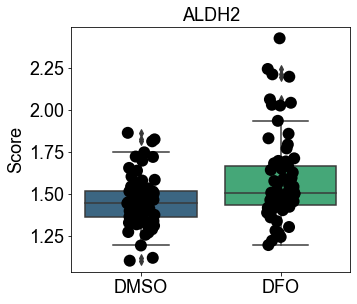

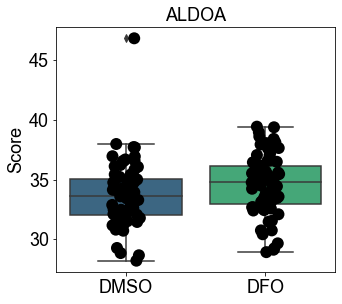

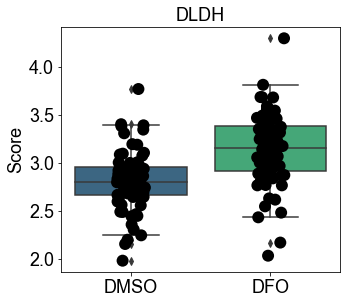

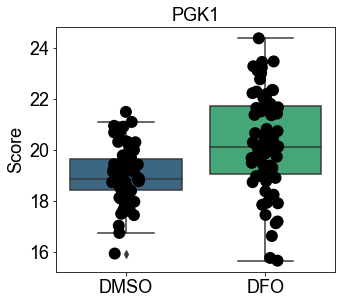

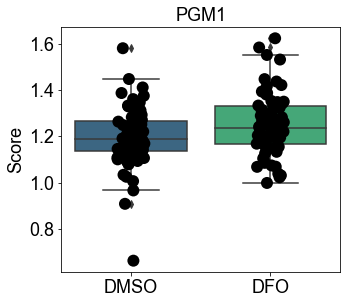

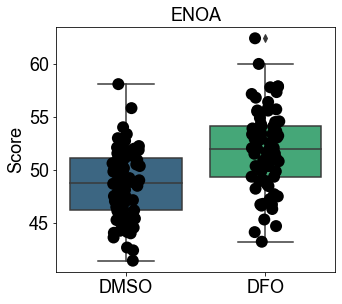

In [50]:
drug_name_list = ['DMSO','DFO']
for protein_name in glycolytic_proteins[0:6]:
    final_df = get_full_df(protein_name ,name_list = drug_name_list)
    plot_bar_scatter(protein_name,df= final_df)

# dysregulation analysis starts here

In [112]:
import re
import math
import statsmodels
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import mannwhitneyu
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
from adjustText import adjust_text

# check CoV

In [52]:
def calculate_cv(row):
    mean = row.mean()
    std_dev = row.std()
    cv = std_dev / mean if mean != 0 else 0
    return cv


In [53]:
interval = 6
chunks = []
total_columns = drugs.shape[1]
num_chunks = total_columns // interval 
cov_dict = {}
cov_dict['DMSO'] = dmso.apply(calculate_cv, axis=1) 
cov_dict['DFO'] = dfo.apply(calculate_cv, axis=1)  
for i in range(0, total_columns, interval):
    # Create a chunk by slicing the DataFrame
    drugcov = drugs.iloc[:, i:i+6].apply(calculate_cv, axis=1)
    drugname_cov = re.sub(r'\d+', '', drugs.iloc[:, i:i+6].columns[1])
    cov_dict[drugname_cov] = drugcov
df_cov = pd.DataFrame(cov_dict)  

In [62]:
def plot_cv_violin(df_long = df_cov.melt(var_name='Drugs', value_name='CV')):
    '''input dataframe format :
    columns as treatments
    rows as CoV values
    '''
    plt.rcParams['font.family'] = 'Arial'
    plt.figure(figsize=(13, 3)) 
    # sns.violinplot(x='Drugs', y='CV', data = df_cov.melt(var_name='Drugs', value_name='CV'))
    sns.violinplot(
        x='Drugs', 
        y='CV', 
        data=df_long, 
        scale='width',       # Adjust the width of the violins
        inner='box',         # Adds a boxplot inside the violin plot
        linewidth=0.5,       # Adjust the linewidth of the violins
        width=0.7,           # Control the width of each violin
        # palette='varidis'       # Use a predefined color palette
    )
    plt.xticks(rotation = 90,fontsize = 9)
    plt.yticks(fontsize = 11)
    plt.xlabel('')
    plt.ylabel('CV(%)',fontsize = 12)
    plt.savefig(f'{figure_save_path}/CoV_violinplot.svg',dpi=800,bbox_inches='tight')
    plt.show()

In [64]:
# plot_cv_violin(df_long = df_cov.melt(var_name='Drugs', value_name='CV'))

In [85]:
# SS by protein features

# # # Initialize the StandardScaler
# scaler = StandardScaler()

# # Fit and transform the data according to rows
# scaled_data = scaler.fit_transform(df_sorted.T).T

# scaled_df = pd.DataFrame(scaled_data, index=df_sorted.index, columns=df_sorted.columns)

# Heatmap analysis

In [128]:
#  calculate mean values of each drug, dmso and dfo 
interval = 6
chunks = []
total_columns = drugs.shape[1]
num_chunks = total_columns // interval 
mean_dict = {}
mean_dict['DMSO'] = dmso.mean(axis = 1).tolist()
mean_dict['DFO'] = dfo.mean(axis = 1).tolist()  
for i in range(0, total_columns, interval):
    # Create a chunk by slicing the DataFrame
    drugmean = drugs.iloc[:, i:i+6].mean(axis = 1).tolist()
    drugname4 = re.sub(r'\d+', '', drugs.iloc[:, i:i+6].columns[1])
    mean_dict[drugname4] = drugmean
df_mean = pd.DataFrame(mean_dict)  

df_mean.index = [item.split('|')[-1].split('_')[0] for item in dfx.index]

In [129]:
df_mean.to_csv(f'{file_save_path}/proteome_mean.csv')

In [130]:
df_mean

,DMSO,DFO,Acamprosate,Acenocoumarol,Adenosylcobalamin,Aminophylline,Asenapine,Azithromycin,Baricitinib,Benzbromarone,...,Thymopentin,Ticlopidine,Triclosan,Trimetazidine,Trimethoprim,Troxerutin,Valbenazine,Vinpocetine,Yohimbine,Zaltoprofen
TRYP,110.299068,106.546652,120.110857,117.900437,105.155997,127.415842,115.580373,109.033120,108.968012,120.378507,...,106.958562,121.702413,118.458989,118.414424,104.805246,109.557259,125.178046,117.886199,118.460491,102.142839
ALBU,105.151159,118.373389,112.937333,102.659879,107.506544,103.978620,98.080027,113.024248,127.568053,97.324514,...,99.180563,109.599331,89.197911,102.744940,88.788966,102.109820,101.999273,85.326938,102.951785,108.792214
FBLL1,7.034581,6.314748,6.627938,6.460353,6.239928,5.332818,6.094304,5.625512,6.846221,5.505161,...,6.500748,6.807369,6.939140,7.138843,6.784814,5.468047,6.516704,6.404549,7.933124,5.265810
DX39A,17.866579,19.100592,17.060517,17.488528,17.554489,17.658677,16.961557,16.917609,17.551704,17.633615,...,17.620892,17.757179,17.914372,16.591848,17.713064,17.443660,18.093589,17.619939,17.668892,19.291410
BACH,2.360683,2.023236,2.238299,2.401992,2.262691,2.322467,2.284830,2.369905,2.255988,2.182058,...,2.359105,2.249674,2.330422,2.299512,2.142636,2.350098,2.423553,2.302880,2.304603,2.276611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SUMO4,7.362597,7.294430,7.621795,7.177537,7.692605,7.007858,7.719789,7.483407,7.330240,6.889868,...,6.997212,7.623899,7.731100,7.468900,7.295605,7.219755,7.177011,7.380208,7.523869,7.296822
SRSF6,26.899866,23.633851,25.099893,26.086000,26.192279,24.543674,26.593315,27.735426,26.484725,26.120190,...,25.192671,25.341963,26.218824,27.681309,27.329055,22.924691,26.070994,26.797979,26.858093,24.194763
SEP11,3.808580,3.693349,3.724688,3.579285,3.828887,3.621633,3.854679,4.030079,3.810611,3.714236,...,3.860443,3.821220,3.633133,3.555290,3.815822,3.613072,3.542208,3.745129,3.472612,3.589171
HBG2,14.052624,14.833818,15.541209,12.710227,12.990026,12.241146,12.709871,14.995860,14.606491,14.234092,...,13.956009,12.601600,11.976412,12.512416,10.671021,12.160030,14.057797,12.141321,13.068631,15.294154


In [131]:
# Subtract the first column from all columns
col_1 = df_mean.iloc[:, 0]
df_minus_col_1 = df_mean.apply(lambda col: col - col_1, axis=0)
wo_updown = df_minus_col_1.iloc[:,1:]
wo_updown.index = [item.split('|')[-1].split('_')[0] for item in df4.index]
wo_updown.to_csv(f'{file_save_path}/proteome_up_down.csv')


In [132]:
# # Initialize the StandardScaler
scaler = StandardScaler()
# Fit and transform the data according to rows
scaled_data = scaler.fit_transform(wo_updown.T).T
new_index = [item.split('|')[-1].split('_')[0] for item in df4.index]
scaled_df2 = pd.DataFrame(scaled_data, index=new_index, columns=wo_updown.columns)
scaled_df2

,DFO,Acamprosate,Acenocoumarol,Adenosylcobalamin,Aminophylline,Asenapine,Azithromycin,Baricitinib,Benzbromarone,Benzoin,...,Thymopentin,Ticlopidine,Triclosan,Trimetazidine,Trimethoprim,Troxerutin,Valbenazine,Vinpocetine,Yohimbine,Zaltoprofen
TRYP,-0.752298,0.639935,0.413057,-0.895035,1.389721,0.174925,-0.497086,-0.503769,0.667407,0.246413,...,-0.710020,0.803293,0.470387,0.465813,-0.931037,-0.443289,1.160033,0.411596,0.470541,-1.204307
ALBU,1.427791,0.959191,0.073250,0.491044,0.186929,-0.321544,0.966683,2.220393,-0.386671,0.639952,...,-0.226675,0.671447,-1.087203,0.080582,-1.122455,0.025834,0.016304,-1.420890,0.098413,0.601872
FBLL1,-0.150093,0.276906,0.048422,-0.252100,-1.488838,-0.450641,-1.089784,0.574508,-1.253868,-0.275301,...,0.103497,0.521538,0.701192,0.973465,0.490787,-1.304469,0.125251,-0.027659,2.056373,-1.580195
DX39A,2.644107,-1.059111,-0.282171,-0.162436,0.026690,-1.238748,-1.318525,-0.167492,-0.018803,0.957648,...,-0.041899,0.205495,0.490836,-1.909857,0.125416,-0.363617,0.816159,-0.043628,0.045232,2.990486
BACH,-3.333831,-0.844710,1.049855,-0.562410,0.129437,-0.306168,0.678482,-0.639980,-1.495640,-0.093890,...,0.553487,-0.713066,0.221508,-0.136245,-1.951912,0.449231,1.299398,-0.097257,-0.077323,-0.401293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SUMO4,-0.130692,0.947163,-0.515563,1.180305,-1.074235,1.269807,0.491517,-0.012787,-1.462718,1.088895,...,-1.109287,0.954090,1.307051,0.443753,-0.126823,-0.376559,-0.517297,0.151733,0.624741,-0.122815
SRSF6,-1.613934,-0.548765,0.167702,0.244920,-0.952892,0.536298,1.366111,0.457401,0.192543,0.562445,...,-0.481356,-0.372886,0.264207,1.326792,1.070858,-2.129182,0.156800,0.684998,0.728675,-1.206397
SEP11,-0.536467,-0.337194,-1.261767,0.325381,-0.992493,0.489381,1.604700,0.209166,-0.403654,0.736418,...,0.526037,0.276629,-0.919367,-1.414344,0.242305,-1.046926,-1.497528,-0.207215,-1.940070,-1.198907
HBG2,0.901696,1.409116,-0.621578,-0.420875,-0.958055,-0.621834,1.017931,0.738632,0.471506,-0.366599,...,0.272035,-0.699497,-1.147951,-0.763470,-2.084322,-1.016240,0.345048,-1.029660,-0.364491,1.231900


In [91]:
scaled_df2.to_csv(f'{file_save_path}/proteome_up_down_scaled.csv')

In [92]:
def remove_digits(lst):
    return [re.sub(r'\d+', '', item) for item in lst]

In [565]:
scaler = StandardScaler()

# # Fit and transform the data according to rows
scaled_data4 = scaler.fit_transform(df4.T).T
new_index4 = [item.split('|')[-1].split('_')[0] for item in df4.index]
scaled_df4 = pd.DataFrame(scaled_data4, index=new_index4, columns=df4.columns)
scaled_df4 

,Acamprosate1,Acamprosate2,Acamprosate3,Acamprosate4,Acamprosate5,Acamprosate6,Acenocoumarol1,Acenocoumarol2,Acenocoumarol3,Acenocoumarol4,...,Yohimbine3,Yohimbine4,Yohimbine5,Yohimbine6,Zaltoprofen1,Zaltoprofen2,Zaltoprofen3,Zaltoprofen4,Zaltoprofen5,Zaltoprofen6
TRYP,0.625679,1.139931,-0.309725,0.213877,-0.139413,0.860350,0.126773,-0.388319,0.640904,-1.178272,...,-0.088024,1.192258,1.834213,-1.451107,-0.328733,0.321502,-1.837112,-0.300320,-1.386511,0.304221
ALBU,-0.311743,-0.455192,-0.112260,0.101430,1.661465,1.883889,0.499758,-0.603346,0.760882,-0.799589,...,0.609665,0.029026,-0.335824,-0.252054,0.857437,0.626177,1.288221,0.224481,-0.735324,-0.384256
FBLL1,0.828981,0.952914,-0.265395,-0.187377,-0.496963,-0.465284,-1.340600,0.827453,1.068036,0.728171,...,0.562023,0.622243,2.463260,1.360661,-1.236811,-1.289226,-0.914557,0.284914,-0.461378,-0.490260
DX39A,-0.502214,-1.125272,0.252744,-0.676443,-1.423937,0.100693,-0.610111,0.759815,0.890900,-2.466999,...,0.287010,-0.549781,0.898157,-0.325377,0.992553,1.167499,2.498288,0.760715,0.185465,0.963331
BACH,0.341427,-0.012907,0.049316,-0.256989,-1.154314,-0.339801,0.883212,-0.186841,-0.619235,1.666854,...,-0.234202,0.383774,0.392356,-1.740726,-1.868482,0.118072,-1.062355,0.609620,0.700142,1.833648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SUMO4,-0.336644,2.061923,1.951555,-0.422773,-1.499003,0.407280,1.118092,-1.640125,-0.829243,-0.254714,...,0.698491,-0.208839,0.058578,-0.687079,-0.023254,0.079546,-0.124457,0.072587,-0.546730,0.708552
SRSF6,0.992085,-1.163293,-1.913240,-0.298629,0.863488,0.111247,-0.388876,-0.476944,0.754280,0.894984,...,0.457132,0.855214,-0.061999,-0.026831,0.588905,-0.043395,-1.588705,-1.266766,0.385429,0.822632
SEP11,1.364698,0.002532,-1.867893,-0.252819,-0.558167,0.206507,-1.654499,-1.589807,0.649381,0.320469,...,-1.565852,-1.296547,-0.435271,-0.043487,-0.117337,-0.540954,-0.730604,0.834294,-0.682743,-0.788102
HBG2,-0.566917,-0.506859,-0.672089,-1.538979,3.548573,3.749211,-0.825936,0.014746,-0.781365,0.910098,...,-1.290330,-0.838770,1.049422,-0.136791,0.285766,0.729958,1.321440,0.285617,0.371663,0.786629


In [451]:
# drug_function

In [452]:
# # column_order = drug_function['drugs'].tolist()
# column_order = clustered_samples['Sample'].tolist()
# # Reindex DataFrame with sorted columns
# df_dysregu = scaled_df[column_order]
# df_sorted

In [93]:
def plot_heatmap(dfheatmap = dmso,low=-4, high=4):
    
    from matplotlib.colors import LinearSegmentedColormap
    plt.rcParams['font.family'] = 'Arial'
    colors = ["#437EB8","#8EBBE7","#D8E2EB","white", "#D8E2EB","#EB6CB6","#E72998"]
    n_bins =10 # Number of bins in the color map
    cmap_name = "custom_diverging"
    custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

    # Create the heatmap with the custom color map
    plt.figure(figsize=(15, 8))
    ax = sns.heatmap(dfheatmap, annot=False, cmap=custom_cmap, cbar=True, vmin=low, vmax = high,
                     cbar_kws={"shrink": 0.2})
    ax.set_xticks([])
    # # Set the color bar ticks and labels
    # cbar = ax.collections[0].colorbar
    # cbar.set_ticks([-3, -2, -1, 0, 1, 2, 3])
    # cbar.set_ticklabels(['-3', '-2', '-1', '0', '1', '2', '3'])

    # Set the title and labels with custom font size
    # plt.title('Scaled Upregulation and Downregulation Heatmap', fontsize=16)
    plt.xlabel('Proteome', fontsize=16)
    plt.ylabel('Drug Candidates', fontsize=16)
    plt.xticks(rotation=0, fontsize=8)  # Ensure all x-tick labels are shown
    plt.yticks(fontsize=10)
#     plt.savefig(f'{figure_save_path}/heatmap.svg',dpi=800,bbox_inches='tight')
    # Show the plot
    plt.show()

from matplotlib.colors import LinearSegmentedColormap

def plot_clusterheatmap(dfheatmap, low=-2, high=2):
    # Define custom color map
#     colors = ["#437EB8", "#8EBBE7", "#D8E2EB", "white", "#D8E2EB", "#EB6CB6", "#E72998"]
#     n_bins = 10  # Number of bins in the color map
#     cmap_name = "custom_diverging"
#     custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
    custom_cmap = "viridis"
    # Create the heatmap with the custom color map
    plt.rcParams['font.family'] = 'Arial'
        # Create the heatmap with the custom color map, figure size, and hidden dendrograms
    ax = sns.clustermap(dfheatmap, annot=False, cmap=custom_cmap, cbar=True, vmin=low, vmax=high,
                        figsize=(21, 9),  # Set the figure size here
                        row_cluster=True,  # Enable row clustering
                        col_cluster=True,  # Enable column clustering
                        dendrogram_ratio=(.001, .001),  # Minimize the dendrogram size
                        tree_kws={'linewidths': 0})  # Make dendrogram lines invisible
#                         cbar_kws={'orientation': 'vertical',  # 'horizontal' or 'vertical'
#                                   'shrink': 20,  # Adjusts the size of the color bar
#                                   'aspect': 50,  # Adjusts the length-to-width ratio of the color bar
#                                   'pad': 0.1,  # Padding between the heatmap and the color bar
#                                   'label': 'Color Scale'  # Label for the color bar
#                                  })
    # Customize the color bar ticks and labels
#     cbar = ax.ax_heatmap.collections[0].colorbar
#     cbar.ax.tick_params(labelsize=35) 
    if ax.cax is not None:
        ax.cax.set_visible(False)
#     ax.ax_heatmap.set_xlabel('Regulation Type', fontsize=14)
#     ax.ax_heatmap.set_ylabel('Drug Candidates', fontsize=14)
    ax.ax_heatmap.set_xticklabels([])
#     ax.ax_heatmap.set_xticklabels(ax.ax_heatmap.get_xticklabels(), rotation=90, fontsize=16)  # Customize x-tick labels
    ax.ax_heatmap.set_yticklabels(ax.ax_heatmap.get_yticklabels(), fontsize=14)  # Customize y-tick labels
    ax.ax_heatmap.tick_params(axis='x', which='both', length=0)
#     plt.xlabel('Regulation Type', fontsize=10)
#     plt.ylabel('Drug Candidates', fontsize=10)
#     plt.xticks([])  # Ensure all x-tick labels are shown
#     plt.yticks(fontsize=10)
#     # Save or display the plot
    # plt.savefig(f'{figure_save_path}/_clustered_heatmap.svg', dpi=800, bbox_inches='tight')
    plt.show()

In [746]:
scaled_df4.T.to_csv(f'{file_save_path}/proteome_scaled_for_chord.csv')

In [728]:
# plot_clusterheatmap(scaled_df2.T,low = -2, high = 2)

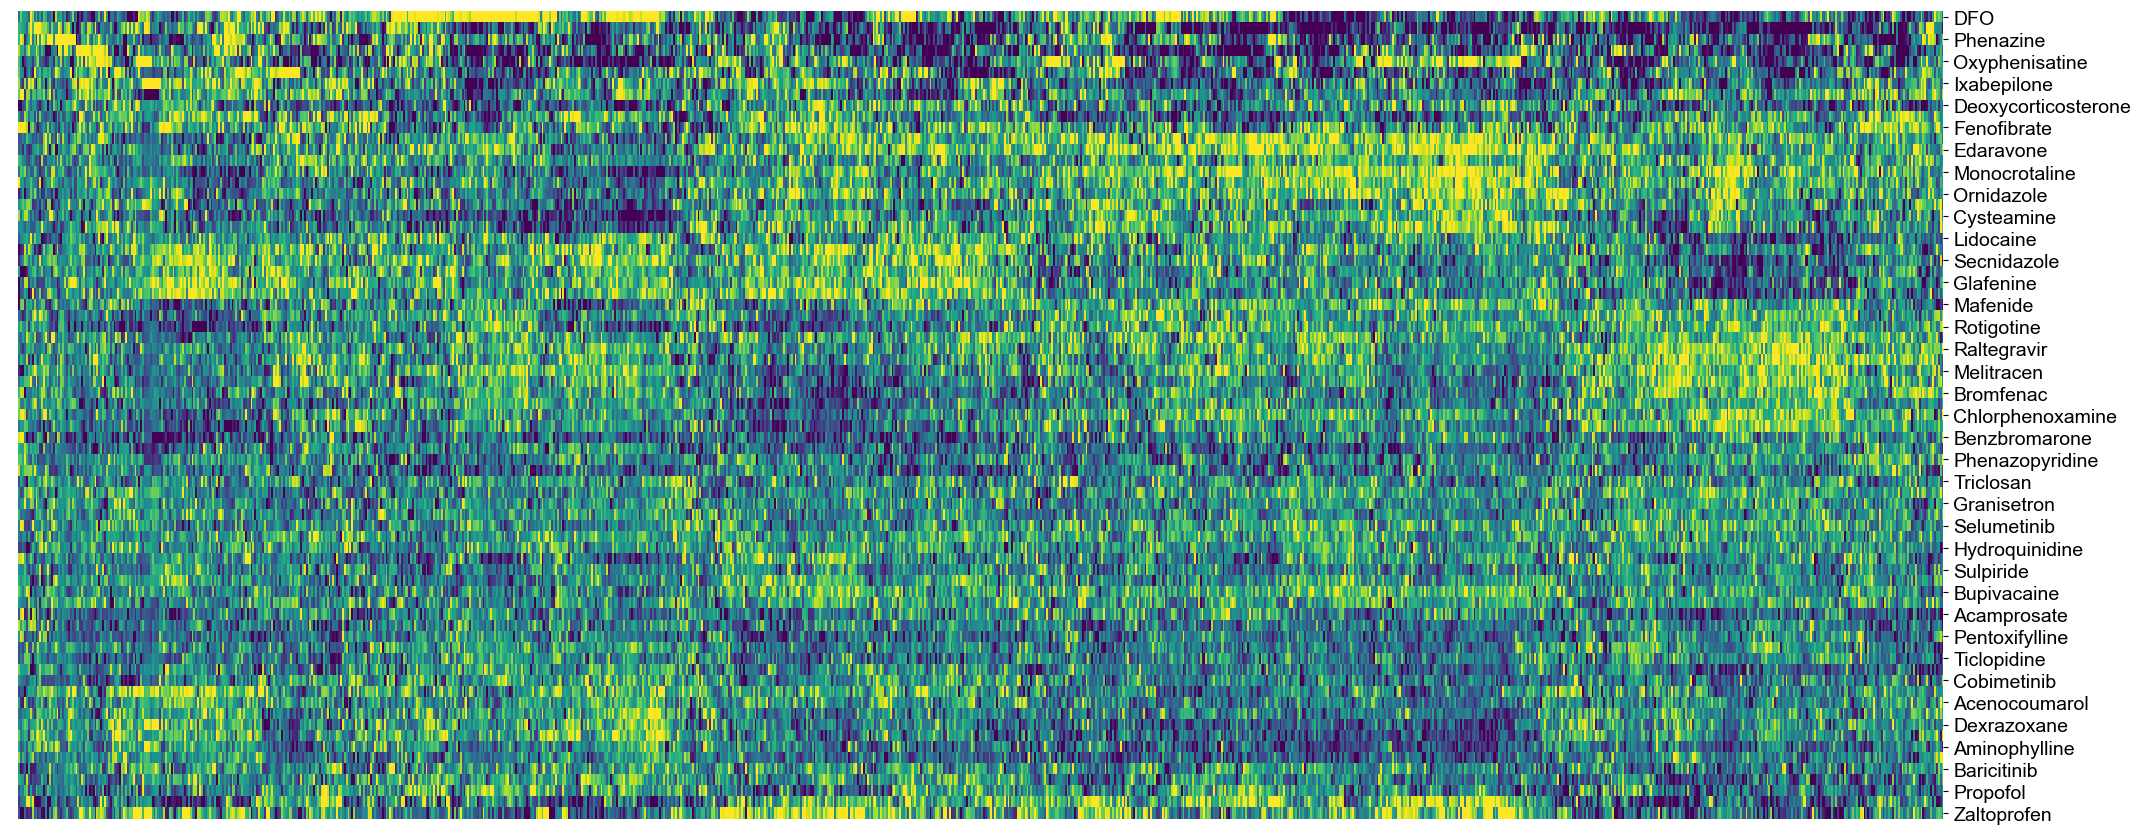

In [94]:
plot_clusterheatmap(dfheatmap = scaled_df2.T,low = -1.7, high = 1.7)

# calculate P values by T-test starts here

In [65]:
def bh_correction(p_values):
    _, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
    return pvals_corrected

def extract_base_name(col_name):
    return re.sub(r'\d+$', '', col_name)
from scipy.stats import ttest_ind

In [66]:
# Extract unique base drug names
drug_names = [extract_base_name(col) for col in drugs]
drug_names = list(set(drug_names))  # Ensure uniqueness

# Get DMSO replicates
dmso_replicates = dmso

# Initialize a dictionary to store p-values for each protein and each drug
results_dict_t = {}
results_dict_w = {}
# Loop through each drug
for drugn in drug_names:
    # Get replicates for the current drug by matching drug name and any following integer
    drug_replicates = drugs[[col for col in drugs.columns if re.match(f'{drugn}\d+', col)]]
    
    # Perform t-test row-wise for each protein
    results_t = []
    results_w = []
    for idx, row in drugs.iterrows():
        t_stat, pval_t = ttest_ind(drug_replicates.loc[idx], dmso_replicates.loc[idx],equal_var=False)
        u_stat, pval_w = mannwhitneyu(drug_replicates.loc[idx], dmso_replicates.loc[idx],alternative='two-sided')

        results_t.append(pval_t)
        results_w.append(pval_w)
    
    results_dict_t[drugn] = results_t
    results_dict_w[drugn] = results_w

In [67]:
dysregulated = pd.DataFrame(results_dict_t)
dysregulated.sort_index(axis = 1,inplace = True)
dysregulated.index = drugs.index
dysregulated.lt(0.05).sum()

Acamprosate          100
Acenocoumarol         53
Adenosylcobalamin     83
Aminophylline        127
Asenapine            133
                    ... 
Troxerutin           104
Valbenazine           94
Vinpocetine          107
Yohimbine             76
Zaltoprofen           94
Length: 72, dtype: int64

In [68]:
# dysregulated.to_csv(f'{file_save_path}/proteome_Pvalues.csv')

In [69]:

# # # Flatten the p-values into a single list for multiple testing correction
# all_p_values = dysregulated.values.flatten()
# # Apply Benjamini-Hochberg correction
# _, corrected_p_values, _, _ = multipletests(all_p_values,alpha=0.05, method='fdr_bh')

# # Reshape the corrected p-values back into the same shape as the original DataFrame
# corrected_dysregulated = pd.DataFrame(corrected_p_values.reshape(dysregulated.shape), 
#                                      index=dysregulated.index, 
#                                      columns=dysregulated.columns)

In [70]:
corrected_dysregulated = dysregulated.apply(bh_correction, axis=0)
corrected_dysregulated.lt(0.05).sum()

Acamprosate           5
Acenocoumarol         1
Adenosylcobalamin     4
Aminophylline         0
Asenapine             2
                     ..
Troxerutin            2
Valbenazine          10
Vinpocetine           2
Yohimbine             2
Zaltoprofen           0
Length: 72, dtype: int64

In [164]:
# corrected_dysregulated.to_csv(f'{file_save_path}/Proteome_Pvalues_afterBH.csv')

In [71]:
# corrected_dysregulated

In [72]:
dfdf= corrected_dysregulated

dys_nums = pd.DataFrame(dfdf.lt(0.05).sum())
dys_nums.columns = ['number']
dys_nums = dys_nums.sort_values(by='number')
# dys_nums.to_csv(r'C:\Users\jiangy5\Box\SMAD PROJECT\new_druganalysis\dysregulated_proteome_afterBH.csv')

In [73]:
dys_nums

,number
Zaltoprofen,0
Aminophylline,0
Trimetazidine,0
Secnidazole,0
Saccharin,0
...,...
Fidaxomicin,46
Benzbromarone,50
Fedratinib,74
Phenazine,85


In [74]:
len([item for item in dys_nums['number'] if item >10])

11

In [99]:
# dys_nums.to_csv(f'{file_save_path}/drug_response_rate_proteome.csv')

In [97]:
dys_nums

,number
Zaltoprofen,0
Aminophylline,0
Trimetazidine,0
Secnidazole,0
Saccharin,0
...,...
Fidaxomicin,46
Benzbromarone,50
Fedratinib,74
Phenazine,85


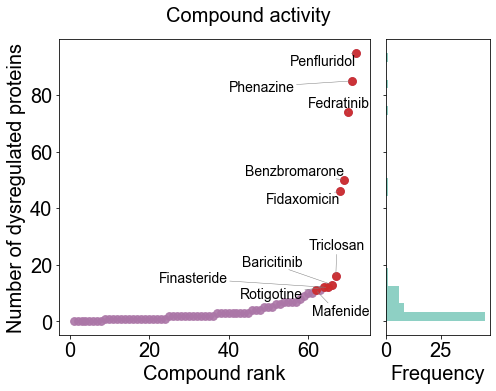

In [111]:
# Prepare your data
# dys_nums is a DataFrame whose index are protein names and with a column 'number'
x = range(1, len(dys_nums) + 1)
y = dys_nums['number'].values

# 1. Create figure & axes in one go (drop the separate plt.figure call)
fig, (ax_scatter, ax_hist) = plt.subplots(
    1, 2,
    figsize=(7, 5.5),
    gridspec_kw={'width_ratios': [3, 1]}
)

# 2. Scatter plot
ax_scatter.scatter(x, y, color='#AB76A7', s=60, alpha=0.9)
ax_scatter.set_xlabel('Compound rank', fontsize=20)
ax_scatter.set_ylabel('Number of dysregulated proteins', fontsize=20)
ax_scatter.tick_params(axis='x', labelsize=20)
ax_scatter.tick_params(axis='y', labelsize=20)

# 3. Find & label the top 10 proteins
top10 = dys_nums.nlargest(10, 'number')
texts = []
for protein, row in top10.iterrows():
    rank = dys_nums.index.get_loc(protein) + 1
    yval = row['number']
    # optional: highlight the top10 in a different color
    ax_scatter.scatter(rank, yval, color='#CE2B2B', s=60, alpha=0.9)
    texts.append(
        ax_scatter.text(
            rank, yval, protein,
            ha='center', va='bottom',
            fontsize=14
        )
    )

# 4. Adjust labels to avoid overlap
adjust_text(
    texts,
    ax=ax_scatter,
    only_move={'points':'y', 'texts':'y'},
    arrowprops=dict(arrowstyle='-', color='gray', lw=0.5)
)

# 5. Histogram of y on the right
ax_hist.hist(y, orientation='horizontal', color='#8ED0C4', bins=30)
ax_hist.set_xlabel('Frequency', fontsize=20)
ax_hist.tick_params(axis='x', labelsize=20)
ax_hist.set_yticklabels([])

# 6. Title, layout, save & show
fig.suptitle('Compound activity', fontsize=20)
plt.tight_layout()
plt.savefig(f'{figure_save_path}/compound_activity_proteome.svg', dpi=800, bbox_inches='tight')
plt.show()

In [76]:
ji = [item.split('|')[-1].split('_')[0] for item in dysregulated.index]

dfdf2 = corrected_dysregulated
dfdf2.index = ji
# dfdf2= dysregulated
dys_pros = pd.DataFrame(dfdf2.T.lt(0.05).sum())
dys_pros.columns = ['number']
dys_pros = dys_pros.sort_values(by='number')
# dys_pros

In [100]:
# dys_pros.to_csv(f'{file_save_path}/proteome_response_rate.csv')

In [98]:
dys_pros

,number
PSA,0
RL24,0
RL19,0
SRSF3,0
RBM3,0
...,...
SNRPA,5
HNRPM,5
G6PI,5
DDB1,6


In [78]:
dys_pros.iloc[-12:,:]

,number
ACO13,4
THIO,4
RS26L,4
BIP,4
LA,4
TKT,4
ACLY,5
SNRPA,5
HNRPM,5
G6PI,5


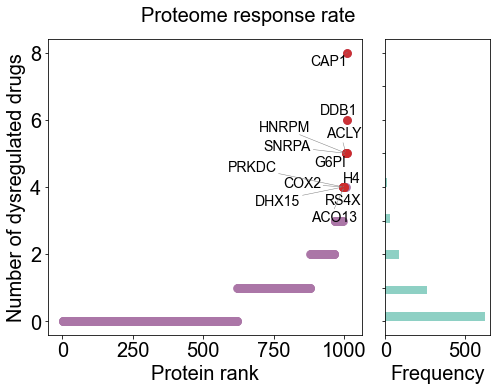

In [110]:
# Prepare your data
# dys_pros is a DataFrame whose index are protein names and with a column 'number'
x = range(1, len(dys_pros) + 1)
y = dys_pros['number'].values

# 1. Create figure & axes in one go (drop the separate plt.figure call)
fig, (ax_scatter, ax_hist) = plt.subplots(
    1, 2,
    figsize=(7, 5.5),
    gridspec_kw={'width_ratios': [3, 1]}
)

# 2. Scatter plot
ax_scatter.scatter(x, y, color='#AB76A7', s=60, alpha=0.9)
ax_scatter.set_xlabel('Protein rank', fontsize=20)
ax_scatter.set_ylabel('Number of dysregulated drugs', fontsize=20)
ax_scatter.tick_params(axis='x', labelsize=20)
ax_scatter.tick_params(axis='y', labelsize=20)

# 3. Find & label the top 10 proteins
top10 = dys_pros.nlargest(12, 'number')
texts = []
for protein, row in top10.iterrows():
    rank = dys_pros.index.get_loc(protein) + 1
    yval = row['number']
    # optional: highlight the top10 in a different color
    ax_scatter.scatter(rank, yval, color='#CE2B2B', s=60, alpha=0.9)
    texts.append(
        ax_scatter.text(
            rank, yval, protein,
            ha='center', va='bottom',
            fontsize=14
        )
    )

# 4. Adjust labels to avoid overlap
adjust_text(
    texts,
    ax=ax_scatter,
    only_move={'points':'y', 'texts':'y'},
    arrowprops=dict(arrowstyle='-', color='gray', lw=0.5)
)

# 5. Histogram of y on the right
ax_hist.hist(y, orientation='horizontal', color='#8ED0C4', bins=30)
ax_hist.set_xlabel('Frequency', fontsize=20)
ax_hist.tick_params(axis='x', labelsize=20)
ax_hist.set_yticklabels([])

# 6. Title, layout, save & show
fig.suptitle('Proteome response rate', fontsize=20)
plt.tight_layout()
plt.savefig(f'{figure_save_path}/proteome_response_rate.svg', dpi=800, bbox_inches='tight')
plt.show()

# How duplicates affect results starts here

In [516]:
from collections import Counter

def find_duplicates(lst):
    counts = Counter(lst)
    return [item for item, count in counts.items() if count > 1]



In [540]:
# find_duplicates(ji)

In [541]:
wo_fc = df_mean.div(df_mean['DMSO'], axis=0)
wo_fc.index = ji
wo_fc

,DMSO,DFO,Acamprosate,Acenocoumarol,Adenosylcobalamin,Aminophylline,Asenapine,Azithromycin,Baricitinib,Benzbromarone,...,Thymopentin,Ticlopidine,Triclosan,Trimetazidine,Trimethoprim,Troxerutin,Valbenazine,Vinpocetine,Yohimbine,Zaltoprofen
TRYP,1.0,0.977818,1.085856,1.071619,0.954599,1.146712,1.040135,0.985333,0.988923,1.100730,...,0.969069,1.091974,1.064798,1.070105,0.948798,0.997554,1.131723,1.068349,1.072558,0.935406
ALBU,1.0,1.138821,1.070533,0.975669,1.023231,0.981921,0.924438,1.075161,1.210696,0.926657,...,0.940702,1.028974,0.841206,0.970118,0.839209,0.972474,0.966693,0.807690,0.982437,1.044781
FBLL1,1.0,0.908132,0.938741,0.924997,0.888023,0.755215,0.860812,0.796391,0.973386,0.788684,...,0.923557,0.958776,0.979248,1.010809,0.964710,0.779911,0.925390,0.907029,1.129101,0.755579
DX39A,1.0,1.085322,0.951432,0.982106,0.983607,0.978352,0.937647,0.946373,0.982198,0.993549,...,0.985280,0.987188,0.989723,0.923859,0.989208,0.974435,1.009007,0.984396,0.988389,1.091156
BACH,1.0,0.863257,0.946249,1.021274,0.959468,0.978482,0.963556,1.004441,0.958759,0.935644,...,1.000337,0.946612,0.980533,0.973792,0.908369,1.004073,1.025831,0.979018,0.973225,0.975076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SUMO4,1.0,1.001961,1.033739,0.977421,1.045756,0.945584,1.041396,1.014790,0.996126,0.943335,...,0.949061,1.026752,1.041518,1.010782,0.988967,0.982382,0.970845,1.001198,1.019154,1.000002
SRSF6,1.0,0.820891,0.912024,0.963106,0.938411,0.893830,0.976087,1.020877,0.977246,0.981846,...,0.936411,0.947842,0.950601,1.020059,1.040887,0.850455,0.928381,0.984642,1.007949,0.919147
SEP11,1.0,0.985600,0.973808,0.935460,1.000140,0.936804,1.007025,1.049184,1.014563,0.983324,...,0.999872,0.986958,0.940521,0.939701,1.007371,0.948444,0.924271,0.979322,0.923436,0.958703
HBG2,1.0,1.067581,1.105300,0.908685,0.923947,0.866015,0.897480,1.066979,1.039120,1.018216,...,0.990147,0.889252,0.845493,0.885817,0.758252,0.866299,0.996698,0.861669,0.928824,1.098162


In [553]:
updown_df = DatasetNormalizeDf.standardscaler(wo_fc.iloc[:,1:].T)

In [557]:
updown_df

,TRYP,ALBU,FBLL1,DX39A,BACH,SMAP,PSD11,PSD12,PGRC1,DFFA,...,RAB1B,H2A1C,CALM3,H12,GNAS1,SUMO4,SRSF6,SEP11,HBG2,H2B1L
DFO,-0.629098,1.560063,-0.052639,2.986600,-3.164628,1.673678,-0.962388,-0.119824,1.473542,1.152320,...,1.312462,0.233669,0.416248,-2.977887,0.803466,0.139270,-2.291159,-0.140664,1.015484,1.337646
Acamprosate,0.624163,0.941379,0.245700,-1.024791,-0.923974,1.185195,-0.413468,1.422591,2.424608,0.889014,...,0.283903,1.798060,-0.708186,0.720977,-0.069137,0.883156,-0.726550,-0.417983,1.391986,0.142421
Acenocoumarol,0.459005,0.081906,0.111738,-0.105770,1.101587,-0.756664,0.879547,-0.309204,-1.000588,1.151491,...,0.073769,-1.477469,0.511567,-0.683114,0.626527,-0.435191,0.150437,-1.319875,-0.570602,1.732988
Adenosylcobalamin,-0.898440,0.512818,-0.248629,-0.060809,-0.567072,0.409324,0.238538,-0.453544,0.197594,-0.291601,...,-0.561696,0.110574,0.337924,-0.951219,-0.728504,1.164443,-0.273526,0.201295,-0.418260,0.583742
Aminophylline,1.330097,0.138553,-1.543070,-0.218265,-0.053726,-0.671589,-0.235491,-0.508910,-0.860037,-1.235006,...,-0.458981,-0.497334,-0.216722,0.240325,-0.826706,-1.180443,-1.038919,-1.288257,-0.996529,-0.764923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Troxerutin,-0.400156,0.052956,-1.302367,-0.335606,0.637187,0.235068,1.626686,1.312949,0.729660,0.391163,...,-0.854547,0.800942,0.085950,1.765054,2.720661,-0.319048,-1.783597,-1.014519,-0.993697,-0.995982
Valbenazine,1.156222,0.000584,0.115570,0.700193,1.224638,-0.079198,0.284084,-0.807369,-0.439838,-0.538900,...,2.820195,-0.799952,0.036204,-1.495912,-0.594155,-0.589128,-0.445726,-1.583011,0.307940,-1.321579
Vinpocetine,0.421070,-1.439986,-0.063386,-0.037180,-0.039251,1.249016,0.462966,-0.302540,0.047322,-1.267917,...,-0.396374,-0.764779,0.572863,-0.792191,-0.391010,0.121393,0.520175,-0.288311,-1.039907,0.054532
Yohimbine,0.469899,0.143227,2.101086,0.082453,-0.195647,-0.504798,-0.550234,-0.591056,-1.125770,-0.122957,...,0.730162,-0.250186,0.383994,-0.213941,0.118457,0.541737,0.920315,-1.602668,-0.369578,-0.845207


In [223]:
# plot_clusterheatmap(dfheatmap = updown_df,low = -2, high = 2)

In [ ]:
# Define thresholds
pval_threshold = 0.05
fold_change_threshold = 2

# Boolean masks for filtering
pval_mask = df_pval < pval_threshold
fold_change_mask = (df_fold_change > fold_change_threshold) | (df_fold_change < -fold_change_threshold)

# Combined mask
combined_mask = pval_mask & fold_change_mask

# Apply the combined mask to filter the DataFrames
filtered_pval = df_pval[combined_mask]
filtered_fold_change = df_fold_change[combined_mask]

# Display the filtered DataFrames
print("Filtered p-values:")
print(filtered_pval)
print("Filtered fold changes:")
print(filtered_fold_change)

# replicates analysis starts here

In [127]:
#  calculate mean values of each drug, dmso and dfo 
def get_any_replicates(df=df_sorted, intervalx = 6,num_chunksx = 72):
    dmso = df.filter(regex='DMSO', axis=1)
    dfo = df.filter(regex='DFO', axis=1)
    drugs = df.loc[:, ~df_sorted.columns.str.contains('DMSO|DFO')]
    chunksx = []
    total_columnsx = drugs.shape[1]
    mean_dictx = {}
    mean_dictx['DMSO'] = dmso.mean(axis = 1).tolist()
    mean_dictx['DFO'] = dfo.mean(axis = 1).tolist()  
    for i in range(0, total_columnsx, 6):
        # Create a chunk by slicing the DataFrame
        drugmeanx = drugs.iloc[:, i:i+intervalx].mean(axis = 1).tolist()
        drugname4x = re.sub(r'\d+', '', drugs.iloc[:, i:i+6].columns[1])
        mean_dictx[drugname4x] = drugmeanx
    df_meanx = pd.DataFrame(mean_dictx)  
    return df_meanx

In [135]:
mean6 = get_any_replicates(df=df_sorted, intervalx = 6,num_chunksx = 72)

In [136]:
mean5 = get_any_replicates(df=df_sorted, intervalx = 5,num_chunksx = 72)

In [137]:
mean4 = get_any_replicates(df=df_sorted, intervalx = 4,num_chunksx = 72)

In [140]:
mean3 = get_any_replicates(df=df_sorted, intervalx = 3,num_chunksx = 72)

In [141]:
mean2 = get_any_replicates(df=df_sorted, intervalx = 2,num_chunksx = 72)

In [142]:
mean1 = get_any_replicates(df=df_sorted, intervalx = 1,num_chunksx = 72)

In [158]:
def get_fold_change(dfdf = mean1):
    col_1 = dfdf.iloc[:, 0]
    df_div_col_1 = dfdf.apply(lambda col: col / col_1, axis=0)
    # wo_updown = df_minus_col_1.iloc[:,1:]
    return df_div_col_1

In [214]:
# plot_heatmap(dfheatmap = get_fold_change(dfdf = mean3).T,low=0.7, high=1.3)

# plot_heatmap(dfheatmap = get_fold_change(dfdf = mean4).T,low=0.7, high=1.3)
# plot_heatmap(dfheatmap = get_fold_change(dfdf = mean5).T,low=0.7, high=1.3)
# plot_heatmap(dfheatmap = get_fold_change(dfdf = mean6).T,low=0.7, high=1.3)
# plot_heatmap(dfheatmap = get_fold_change(dfdf = mean1).T,low=0.7, high=1.3)
# plot_heatmap(dfheatmap = get_fold_change(dfdf = mean2).T,low=0.7, high=1.3)

In [289]:
len(get_fold_change(dfdf = mean4).values.flatten())

74888

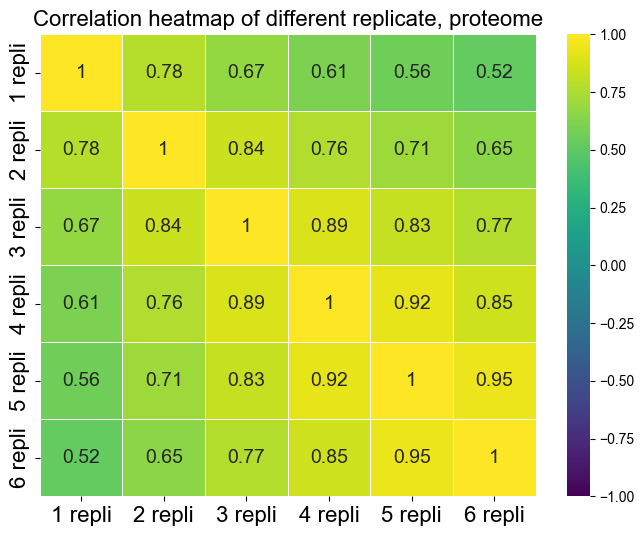

In [222]:
dataframes = [get_fold_change(dfdf = mean1), 
              get_fold_change(dfdf = mean2), 
              get_fold_change(dfdf = mean3), 
              get_fold_change(dfdf = mean4),
              get_fold_change(dfdf = mean5),
              get_fold_change(dfdf = mean6)]
# Flatten the DataFrames into a single Series
flattened_series = [df.values.flatten() for df in dataframes]
# Compute the correlation matrix
correlation_matrix = np.corrcoef(flattened_series)
# Create a DataFrame for the correlation matrix with proper labels
correlation_df = pd.DataFrame(correlation_matrix, 
                              columns=[f'{i+1} repli' for i in range(6)], 
                              index=[f'{i+1} repli' for i in range(6)])
# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_df, annot=True, cmap='viridis', vmin=-1, vmax=1, linewidths=.5,annot_kws={"size": 14})
plt.xticks(fontsize=16)  # Ensure all x-tick labels are shown
plt.yticks(fontsize=16)
plt.title('Correlation heatmap of different replicate, proteome',fontsize=16)
plt.show()

In [199]:
mean1

,DMSO,DFO,Acamprosate,Acenocoumarol,Adenosylcobalamin,Aminophylline,Asenapine,Azithromycin,Baricitinib,Benzbromarone,...,Thymopentin,Ticlopidine,Triclosan,Trimetazidine,Trimethoprim,Troxerutin,Valbenazine,Vinpocetine,Yohimbine,Zaltoprofen
0,113.674683,111.153127,127.585030,118.471824,109.838661,152.997865,122.572938,113.151896,125.395099,134.368019,...,121.106705,103.354224,105.797632,132.738380,104.235819,117.247562,139.923676,135.250205,124.022289,110.151382
1,108.541145,123.608921,101.644514,116.921595,100.899812,114.174701,102.036799,97.846228,132.185821,100.012661,...,103.911377,111.461255,94.937654,109.923564,93.951303,104.493849,114.355319,98.661987,107.069922,123.655138
2,7.247863,6.582013,8.170803,4.308410,8.702181,4.200933,8.223901,4.617521,8.401657,4.941354,...,5.007864,7.807094,8.066813,8.646388,4.931669,6.341446,9.314763,5.182370,4.710721,4.493180
3,18.420391,19.992050,17.619234,17.451645,17.898174,19.210525,17.061149,18.410099,18.103095,17.853077,...,18.295926,17.268334,17.666073,19.287827,17.656737,16.526117,19.645927,18.623772,17.870767,19.940947
4,2.430539,2.098179,2.440601,2.574272,2.165069,2.269253,2.218996,2.186188,2.240874,2.490614,...,2.409264,1.994011,2.640074,2.635252,2.184794,2.571450,2.628386,2.758279,2.869429,1.895365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1007,7.590512,7.605399,7.310063,8.429860,7.122185,7.415712,7.270859,6.757996,7.841507,7.960187,...,7.261094,7.419246,8.711392,8.177227,8.510780,6.645511,7.798077,7.646684,8.940831,7.551298
1008,27.354004,22.454652,29.627563,24.359453,30.279462,22.845178,26.525852,23.912385,28.468728,28.555870,...,25.331281,25.177594,24.799978,29.190594,27.410297,10.531163,23.409095,27.208785,27.540354,28.089506
1009,3.912753,3.856409,4.407123,3.243700,4.306876,3.268753,4.208790,3.994623,4.369714,3.340127,...,4.212522,4.502351,3.461186,3.145366,3.463783,3.038003,3.479079,3.831578,3.279393,3.836033
1010,14.496026,15.475686,12.714033,12.020566,13.808381,13.393069,12.655677,15.505032,14.884093,15.304257,...,13.623390,13.225923,12.472616,14.347498,12.049371,11.732339,16.037278,11.299214,13.470754,14.996902


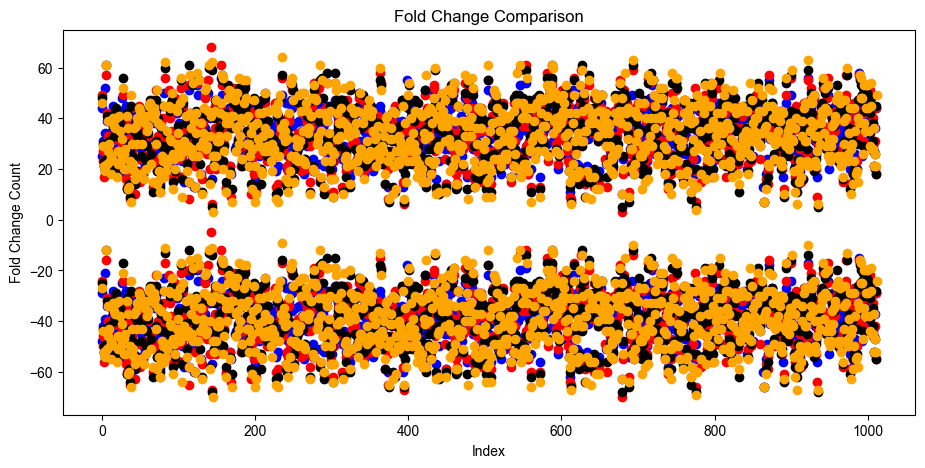

In [192]:
# Example data
data_length = 1012
x = np.arange(data_length)  # X-axis positions

# Calculate the fold change sums
fold_change1_gt_1 = get_fold_change(dfdf=mean1).T.gt(1.0).sum()
fold_change1_lt_1 = -get_fold_change(dfdf=mean1).T.lt(1.0).sum()
fold_change2_gt_1 = get_fold_change(dfdf=mean2).T.gt(1.0).sum()
fold_change2_lt_1 = -get_fold_change(dfdf=mean2).T.lt(1.0).sum()
fold_change3_gt_1 = get_fold_change(dfdf=mean3).T.gt(1.0).sum()
fold_change3_lt_1 = -get_fold_change(dfdf=mean3).T.lt(1.0).sum()
fold_change4_gt_1 = get_fold_change(dfdf=mean4).T.gt(1.0).sum()
fold_change4_lt_1 = -get_fold_change(dfdf=mean4).T.lt(1.0).sum()
fold_change5_gt_1 = get_fold_change(dfdf=mean5).T.gt(1.0).sum()
fold_change5_lt_1 = -get_fold_change(dfdf=mean5).T.lt(1.0).sum()
fold_change6_gt_1 = get_fold_change(dfdf=mean6).T.gt(1.0).sum()
fold_change6_lt_1 = -get_fold_change(dfdf=mean6).T.lt(1.0).sum()

# Define scatter width and offsets for non-overlapping scatters
scatter_width = 0.2
offset1 = -scatter_width
offset2 = scatter_width

plt.figure(figsize=(11, 5))

# Plot the scatters with offsets to avoid overlap
plt.scatter(x + offset1, fold_change1_gt_1, color="blue",  label="mean1.T")
plt.scatter(x + offset1, fold_change1_lt_1, color="blue",  label="mean1.T")

plt.scatter(x + offset2, fold_change2_gt_1, color="red",  label="Mean2")
plt.scatter(x + offset2, fold_change2_lt_1, color="red",  label="Mean2")
plt.scatter(x + 2*offset2, fold_change3_gt_1, color="black",  label="Mean3")
plt.scatter(x + 2*offset2, fold_change3_lt_1, color="black",  label="Mean3")
plt.scatter(x + 3*offset2, fold_change4_gt_1, color="orange", label="Mean4")
plt.scatter(x + 3*offset2, fold_change4_lt_1, color="orange", label="Mean4")

# Add labels, title, and legend
plt.xlabel('Index')
plt.ylabel('Fold Change Count')
plt.title('Fold Change Comparison')
# plt.legend()

plt.show()


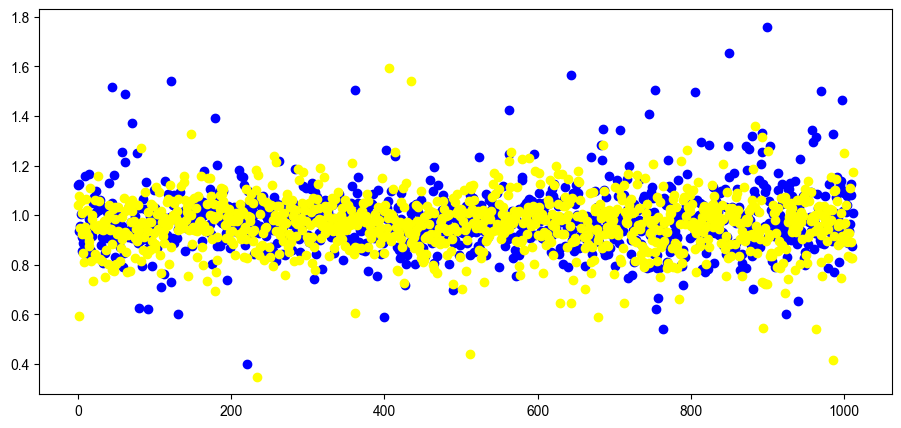

In [150]:
plt.figure(figsize=(11, 5))

plt.scatter(range(1012),df_div_col_1['Acamprosate'],color = "blue")
plt.scatter(range(1012),df_div_col_1['Acenocoumarol'],color = "yellow")


In [315]:
def get_pvalues(num = 3,dfdf = df_sorted):
    dmso = dfdf.filter(regex='DMSO', axis=1)
    dfo = dfdf.filter(regex='DFO', axis=1)
    drugs = dfdf.loc[:, ~df_sorted.columns.str.contains('DMSO|DFO')]
    results_dict_w = {}
    results_dict_t = {}
    interval = 6
    for i in range(0, total_columns, interval):
        # Create a chunk by slicing the DataFrame
        drugname = re.sub(r'\d+', '', drugs.iloc[:, i:i+6].columns[1])
        results_t = []
        results_w = []

        for j in range(drugs.shape[0]):
            dmsopro = dmso.iloc[j, :72].tolist()
            drugpro = drugs.iloc[j, i:i+num].tolist()

            # Calculate the p-value of the t-test between drug and DMSO profiles
            pval_t = stats.ttest_ind(drugpro, dmsopro, equal_var=False)[1]
            pval_w = mannwhitneyu(drugpro, dmsopro)[1]
            results_t.append(pval_t)
            results_w.append(pval_w)

        results_dict_t[drugname] = results_t
        results_dict_w[drugname] = results_w
    dysregulated = pd.DataFrame(results_dict_t)
    dysregulated2 = pd.DataFrame(results_dict_w)
    return [dysregulated,dysregulated2]


def get_variance(num = 3,dfdf = df_sorted):
    dmso = dfdf.filter(regex='DMSO', axis=1)
    dfo = dfdf.filter(regex='DFO', axis=1)
    drugs = dfdf.loc[:, ~df_sorted.columns.str.contains('DMSO|DFO')]
    results_dict_v= {}
    interval = 6
    for i in range(0, total_columns, interval):
        # Create a chunk by slicing the DataFrame
        drugname = re.sub(r'\d+', '', drugs.iloc[:, i:i+6].columns[1])
        results_v = []
        for j in range(drugs.shape[0]):
#             dmsopro = dmso.iloc[j, :72].tolist()
            drugpro = drugs.iloc[j, i:i+num].tolist()
            # Calculate the p-value of the t-test between drug and DMSO profiles
            vari = np.var(drugpro)

            results_v.append(vari)           
        results_dict_v[drugname] = results_v
    dysregulated = pd.DataFrame(results_dict_v)
    return dysregulated 

def get_cv(num = 3,dfdf = df_sorted):
    dmso = dfdf.filter(regex='DMSO', axis=1)
    dfo = dfdf.filter(regex='DFO', axis=1)
    drugs = dfdf.loc[:, ~df_sorted.columns.str.contains('DMSO|DFO')]
    results_dict_v= {}
    interval = 6
    for i in range(0, total_columns, interval):
        # Create a chunk by slicing the DataFrame
        drugname = re.sub(r'\d+', '', drugs.iloc[:, i:i+6].columns[1])
        results_v = []
        for j in range(drugs.shape[0]):
#             dmsopro = dmso.iloc[j, :72].tolist()
            drugpro = drugs.iloc[j, i:i+num].tolist()
            # Calculate the p-value of the t-test between drug and DMSO profiles
#             vari = np.var(drugpro)
            mean = np.mean(drugpro)
            std_dev = np.std(drugpro)
            cv = std_dev / mean
            results_v.append(cv)           
        results_dict_v[drugname] = results_v
    dysregulated = pd.DataFrame(results_dict_v)
    return dysregulated 

In [316]:
get_cv(num = 6,dfdf = df_sorted)

,Acamprosate,Acenocoumarol,Adenosylcobalamin,Aminophylline,Asenapine,Azithromycin,Baricitinib,Benzbromarone,Benzoin,Bromfenac,...,Thymopentin,Ticlopidine,Triclosan,Trimetazidine,Trimethoprim,Troxerutin,Valbenazine,Vinpocetine,Yohimbine,Zaltoprofen
0,0.077360,0.136289,0.114230,0.107839,0.048648,0.149645,0.078020,0.087286,0.061478,0.111196,...,0.111234,0.143130,0.069030,0.115462,0.075864,0.081786,0.153599,0.123203,0.155785,0.139490
1,0.153134,0.099393,0.089454,0.139930,0.082488,0.176189,0.074916,0.163322,0.123123,0.054651,...,0.074844,0.053587,0.101498,0.048315,0.092553,0.041876,0.096971,0.094521,0.057239,0.116177
2,0.156330,0.241669,0.347465,0.186327,0.246856,0.296360,0.240641,0.346757,0.242611,0.289111,...,0.298486,0.271712,0.161481,0.154848,0.311210,0.263615,0.414355,0.189255,0.233816,0.175611
3,0.053419,0.096908,0.071105,0.054672,0.062992,0.064120,0.081965,0.032024,0.051852,0.069687,...,0.070799,0.075313,0.023158,0.112081,0.043143,0.062132,0.061235,0.071805,0.047127,0.054106
4,0.050294,0.073795,0.094905,0.030836,0.053149,0.061011,0.077542,0.099969,0.043623,0.087118,...,0.043081,0.099092,0.070823,0.063261,0.045253,0.087212,0.043790,0.089535,0.121467,0.126360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1007,0.126557,0.090550,0.060836,0.075474,0.047782,0.109490,0.076664,0.074321,0.128421,0.163258,...,0.052678,0.070063,0.068434,0.087028,0.074331,0.093341,0.037856,0.061247,0.081437,0.037581
1008,0.159336,0.075899,0.113437,0.062230,0.057149,0.099111,0.069043,0.056032,0.061136,0.066671,...,0.115670,0.172583,0.049310,0.090551,0.111759,0.260957,0.075718,0.037336,0.056876,0.139891
1009,0.097406,0.094346,0.102876,0.075957,0.089949,0.052611,0.109986,0.100703,0.021085,0.068946,...,0.057196,0.088064,0.049960,0.087408,0.087559,0.113385,0.094540,0.066265,0.091239,0.058408
1010,0.356841,0.135481,0.056190,0.080403,0.092957,0.094229,0.100745,0.218948,0.084150,0.150403,...,0.065334,0.148132,0.049124,0.092926,0.065549,0.083888,0.110894,0.108704,0.143486,0.062039


In [313]:
get_variance(num = 4,dfdf = df_sorted)

,Acamprosate,Acenocoumarol,Adenosylcobalamin,Aminophylline,Asenapine,Azithromycin,Baricitinib,Benzbromarone,Benzoin,Bromfenac,...,Thymopentin,Ticlopidine,Triclosan,Trimetazidine,Trimethoprim,Troxerutin,Valbenazine,Vinpocetine,Yohimbine,Zaltoprofen
0,0.078627,0.109105,0.104644,0.128016,0.053792,0.084432,0.088364,0.081002,0.071456,0.123768,...,0.112140,0.175672,0.082716,0.140772,0.044318,0.054977,0.184726,0.143609,0.075850,0.136494
1,0.038029,0.119081,0.102658,0.165903,0.083296,0.045285,0.074752,0.099513,0.052633,0.054459,...,0.031976,0.050426,0.080160,0.056316,0.066369,0.026284,0.070731,0.111973,0.057547,0.059588
2,0.137078,0.236952,0.389917,0.222918,0.239448,0.321153,0.238435,0.289759,0.251771,0.306454,...,0.280226,0.251778,0.038808,0.093027,0.265854,0.225637,0.469555,0.179674,0.208014,0.214133
3,0.043855,0.117748,0.058871,0.055387,0.031541,0.070139,0.033128,0.015526,0.051001,0.054336,...,0.084139,0.072930,0.024324,0.073542,0.051251,0.075038,0.027005,0.044372,0.032976,0.051194
4,0.022237,0.089792,0.092301,0.031424,0.041213,0.061655,0.037783,0.083187,0.025063,0.087929,...,0.040631,0.065665,0.047261,0.070584,0.015402,0.070158,0.039856,0.084084,0.104826,0.108185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1007,0.112171,0.106658,0.073035,0.069968,0.057535,0.110481,0.038054,0.084781,0.121506,0.191507,...,0.060187,0.069879,0.073121,0.079103,0.088229,0.109548,0.036386,0.025607,0.082482,0.008450
1008,0.174831,0.090600,0.119631,0.021039,0.058147,0.098753,0.074441,0.046096,0.047411,0.061633,...,0.120442,0.179237,0.035947,0.056751,0.096882,0.322467,0.065417,0.028686,0.034796,0.143053
1009,0.116169,0.111556,0.119878,0.081785,0.108398,0.059000,0.133403,0.119325,0.025281,0.075439,...,0.064034,0.106005,0.051969,0.105142,0.099481,0.114790,0.054437,0.057813,0.104988,0.060805
1010,0.093135,0.137595,0.046189,0.092614,0.074397,0.109824,0.035716,0.126418,0.082465,0.160386,...,0.074681,0.168647,0.053425,0.061466,0.049963,0.063123,0.126744,0.130957,0.093865,0.071174


In [228]:
# took a long time to finish this cell

pval2 = get_pvalues(num = 2, dfdf = df_sorted)
pval3 = get_pvalues(num = 3, dfdf = df_sorted)
pval4 = get_pvalues(num = 4, dfdf = df_sorted)
pval5 = get_pvalues(num = 5, dfdf = df_sorted)
pval6 = get_pvalues(num = 6, dfdf = df_sorted)


In [290]:
# took a long time to finish this cell

pval2 = get_pvalues(num = 2, dfdf = df_sorted)

In [325]:
get_bh_corr_df(df= pval2)

,number
Acamprosate,58
Acenocoumarol,74
Adenosylcobalamin,63
Aminophylline,81
Asenapine,78
...,...
Troxerutin,67
Valbenazine,58
Vinpocetine,56
Yohimbine,59


In [246]:
def get_bh_corr_df(df= pval3):
    dfdfdf= df.apply(bh_correction)

    dys_nums_x = pd.DataFrame(dfdfdf.lt(0.05).sum())
    dys_nums_x.columns = ['number']
    # dys_nums_x = dys_nums_x.sort_values(by='number')
    return dys_nums_x

In [291]:
# get_bh_corr_df(df= pval3)

In [292]:
# get_bh_corr_df(df= pval4)

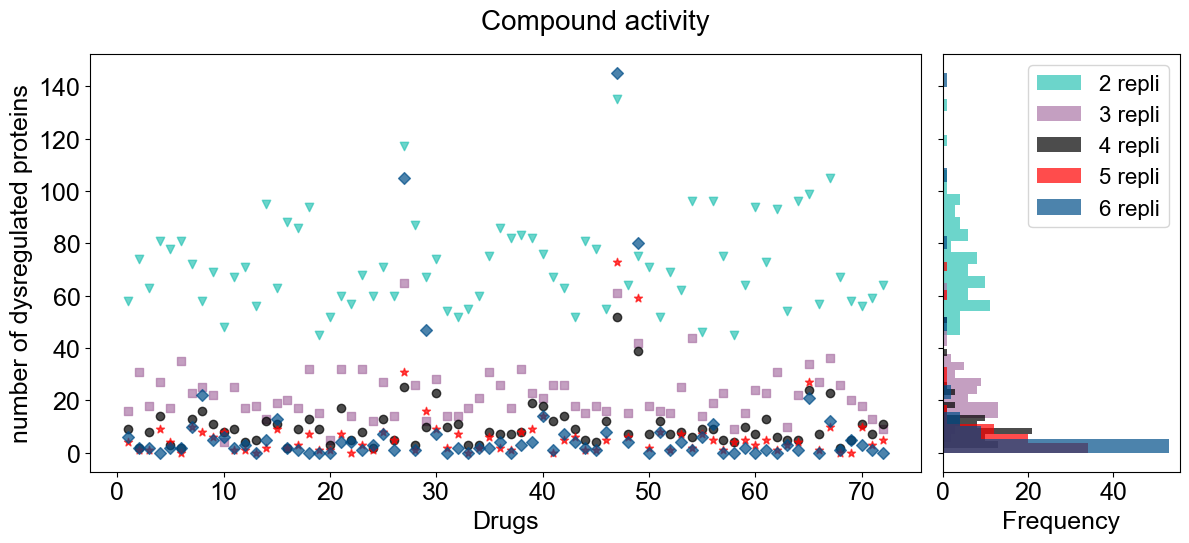

In [321]:
# plot the dysregulation dataset 
x = range(1,73)  # x coordinates
y0 = get_bh_corr_df(df= pval2).number.values
y1 = get_bh_corr_df(df= pval3).number.values 
y2 = get_bh_corr_df(df= pval4).number.values 
y3 = get_bh_corr_df(df= pval5).number.values 
y4 = get_bh_corr_df(df= pval6).number.values 
plt.rcParams['font.family'] = 'Arial'
# Create a subplot grid with 1 row and 2 columns
fig, (ax_scatter, ax_hist) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3.5, 1]},figsize=(12, 5.5))
# Scatter plot on the first subplot
ax_scatter.scatter(x, y0, color='#2ec4b6', marker='v',alpha=0.7)
ax_scatter.scatter(x, y1, color='#AB76A7', marker='s',alpha=0.7)
ax_scatter.scatter(x, y2, color='black', marker='o',alpha=0.7)
ax_scatter.scatter(x, y3, color='red', marker='*',alpha=0.7)
ax_scatter.scatter(x, y4, color='#004E89', marker='D',alpha=0.7)

ax_scatter.set_xlabel('Drugs',fontsize=18)
ax_scatter.set_ylabel('number of dysregulated proteins',fontsize=18)
ax_scatter.tick_params(axis='x', labelsize = 18)
ax_scatter.tick_params(axis='y', labelsize = 18)
# ax_scatter.set_title('Scatter Plot')

# Histogram of Y values on the second subplot
ax_hist.hist(y0, orientation='horizontal', color='#2ec4b6', alpha=0.7, bins=20,label = '2 repli',)
ax_hist.hist(y1, orientation='horizontal', color='#AB76A7', alpha=0.7, bins=20,label = '3 repli',)
ax_hist.hist(y2, orientation='horizontal', color='black', alpha=0.7, bins=20,label = '4 repli')
ax_hist.hist(y3, orientation='horizontal', color='red',alpha=0.7, bins=20,label = '5 repli')
ax_hist.hist(y4, orientation='horizontal', color='#004E89',alpha=0.7, bins=28,label = '6 repli')
ax_hist.set_xlabel('Frequency',fontsize=18)
ax_hist.tick_params(axis='x', labelsize=18)
ax_hist.set_yticklabels([])  # Hide y-axis labels for clarity
# ax_hist.set_title('Histogram of Y')
fig.suptitle('Compound activity', fontsize=20)
# Adjust layout to prevent overlap
plt.tight_layout()
ax_hist.legend(loc='upper right', fontsize=16)
# plt.savefig(f'{figure_save_path}/compound_activity.svg',dpi=800,bbox_inches='tight')
plt.show()

In [236]:
pval6.apply(bh_correction).lt(0.05).sum()

Acamprosate          6
Acenocoumarol        2
Adenosylcobalamin    2
Aminophylline        0
Asenapine            2
                    ..
Troxerutin           1
Valbenazine          5
Vinpocetine          3
Yohimbine            1
Zaltoprofen          0
Length: 72, dtype: int64

# correlation among drugs

In [190]:
wo_updown

,DFO,Acamprosate,Acenocoumarol,Adenosylcobalamin,Aminophylline,Asenapine,Azithromycin,Baricitinib,Benzbromarone,Benzoin,...,Thymopentin,Ticlopidine,Triclosan,Trimetazidine,Trimethoprim,Troxerutin,Valbenazine,Vinpocetine,Yohimbine,Zaltoprofen
TRYP,-2.521556,9.759693,8.141233,-5.160953,16.677448,4.562319,-1.667229,-1.259173,11.450439,5.224745,...,-3.516018,10.455157,7.365874,7.969179,-5.820426,-0.278053,14.973572,7.769497,8.247991,-7.342666
ALBU,15.067776,7.655783,-2.640922,2.521515,-1.962278,-8.201610,8.158018,22.869234,-7.960747,3.045340,...,-6.436226,3.144917,-17.235642,-3.243471,-17.452417,-2.987755,-3.615186,-20.873586,-1.906281,4.860623
FBLL1,-0.665849,-0.443997,-0.543614,-0.811591,-1.774168,-1.008818,-1.475728,-0.192898,-1.531592,-0.875510,...,-0.554046,-0.298784,-0.150408,0.078341,-0.255774,-1.595175,-0.540765,-0.673841,0.935710,-1.771526
DX39A,1.571659,-0.894646,-0.329608,-0.301965,-0.398773,-1.148573,-0.987826,-0.327917,-0.118838,0.111480,...,-0.271144,-0.236009,-0.189307,-1.402546,-0.198798,-0.470918,0.165918,-0.287438,-0.213884,1.679123
BACH,-0.332360,-0.130645,0.051706,-0.098515,-0.052301,-0.088578,0.010794,-0.100238,-0.156420,-0.070627,...,0.000820,-0.129761,-0.047316,-0.063699,-0.222712,0.009899,0.062784,-0.050998,-0.065077,-0.060579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SUMO4,0.014887,0.256099,-0.171388,0.347309,-0.413043,0.314215,0.112265,-0.029408,-0.430115,0.252299,...,-0.386651,0.203063,0.315143,0.081841,-0.083744,-0.133727,-0.221303,0.009090,0.145391,0.000014
SRSF6,-4.899352,-2.406490,-1.009203,-1.684695,-2.904182,-0.654116,0.571083,-0.622404,-0.496581,-0.837278,...,-1.739410,-1.426736,-1.351253,0.548683,1.118437,-4.090663,-1.959058,-0.420107,0.217428,-2.211653
SEP11,-0.056344,-0.102481,-0.252529,0.000548,-0.247269,0.027487,0.192447,0.056980,-0.065248,0.043224,...,-0.000499,-0.051031,-0.232728,-0.235935,0.028842,-0.201727,-0.296307,-0.080908,-0.299578,-0.161587
HBG2,0.979660,1.526428,-1.323707,-1.102471,-1.942252,-1.486130,0.970922,0.567089,0.264059,-1.115547,...,-0.142836,-1.605403,-2.239741,-1.655195,-3.504387,-1.938139,-0.047859,-2.005247,-1.031774,1.422965


In [191]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity


df = wo_updown
# Assuming your dataframe is named df
column_vectors = df.columns
n = len(column_vectors)

# Initialize an empty matrix to store correlations
correlation_matrix = np.zeros((n, n))

# Calculate pairwise correlation manually between every two vectors (columns)
for i in range(n):
    for j in range(n):
        # Calculate correlation between column i and column j
        correlation_matrix[i, j] = np.corrcoef(df[column_vectors[i]], df[column_vectors[j]])[0, 1]

# Convert the matrix to a DataFrame for better visualization and manipulation
correlation_df = pd.DataFrame(correlation_matrix, index=column_vectors, columns=column_vectors)

correlation_df2 = df.corr(method='pearson')

df_transposed = df.T

# Compute cosine similarity between the columns (now rows after transpose)
cosine_sim_matrix = cosine_similarity(df_transposed)

# Convert the result to a DataFrame for better visualization
cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=df.columns, columns=df.columns)

In [193]:
correlation_df.to_csv(f'{file_save_path}/proteome_correlation.csv')

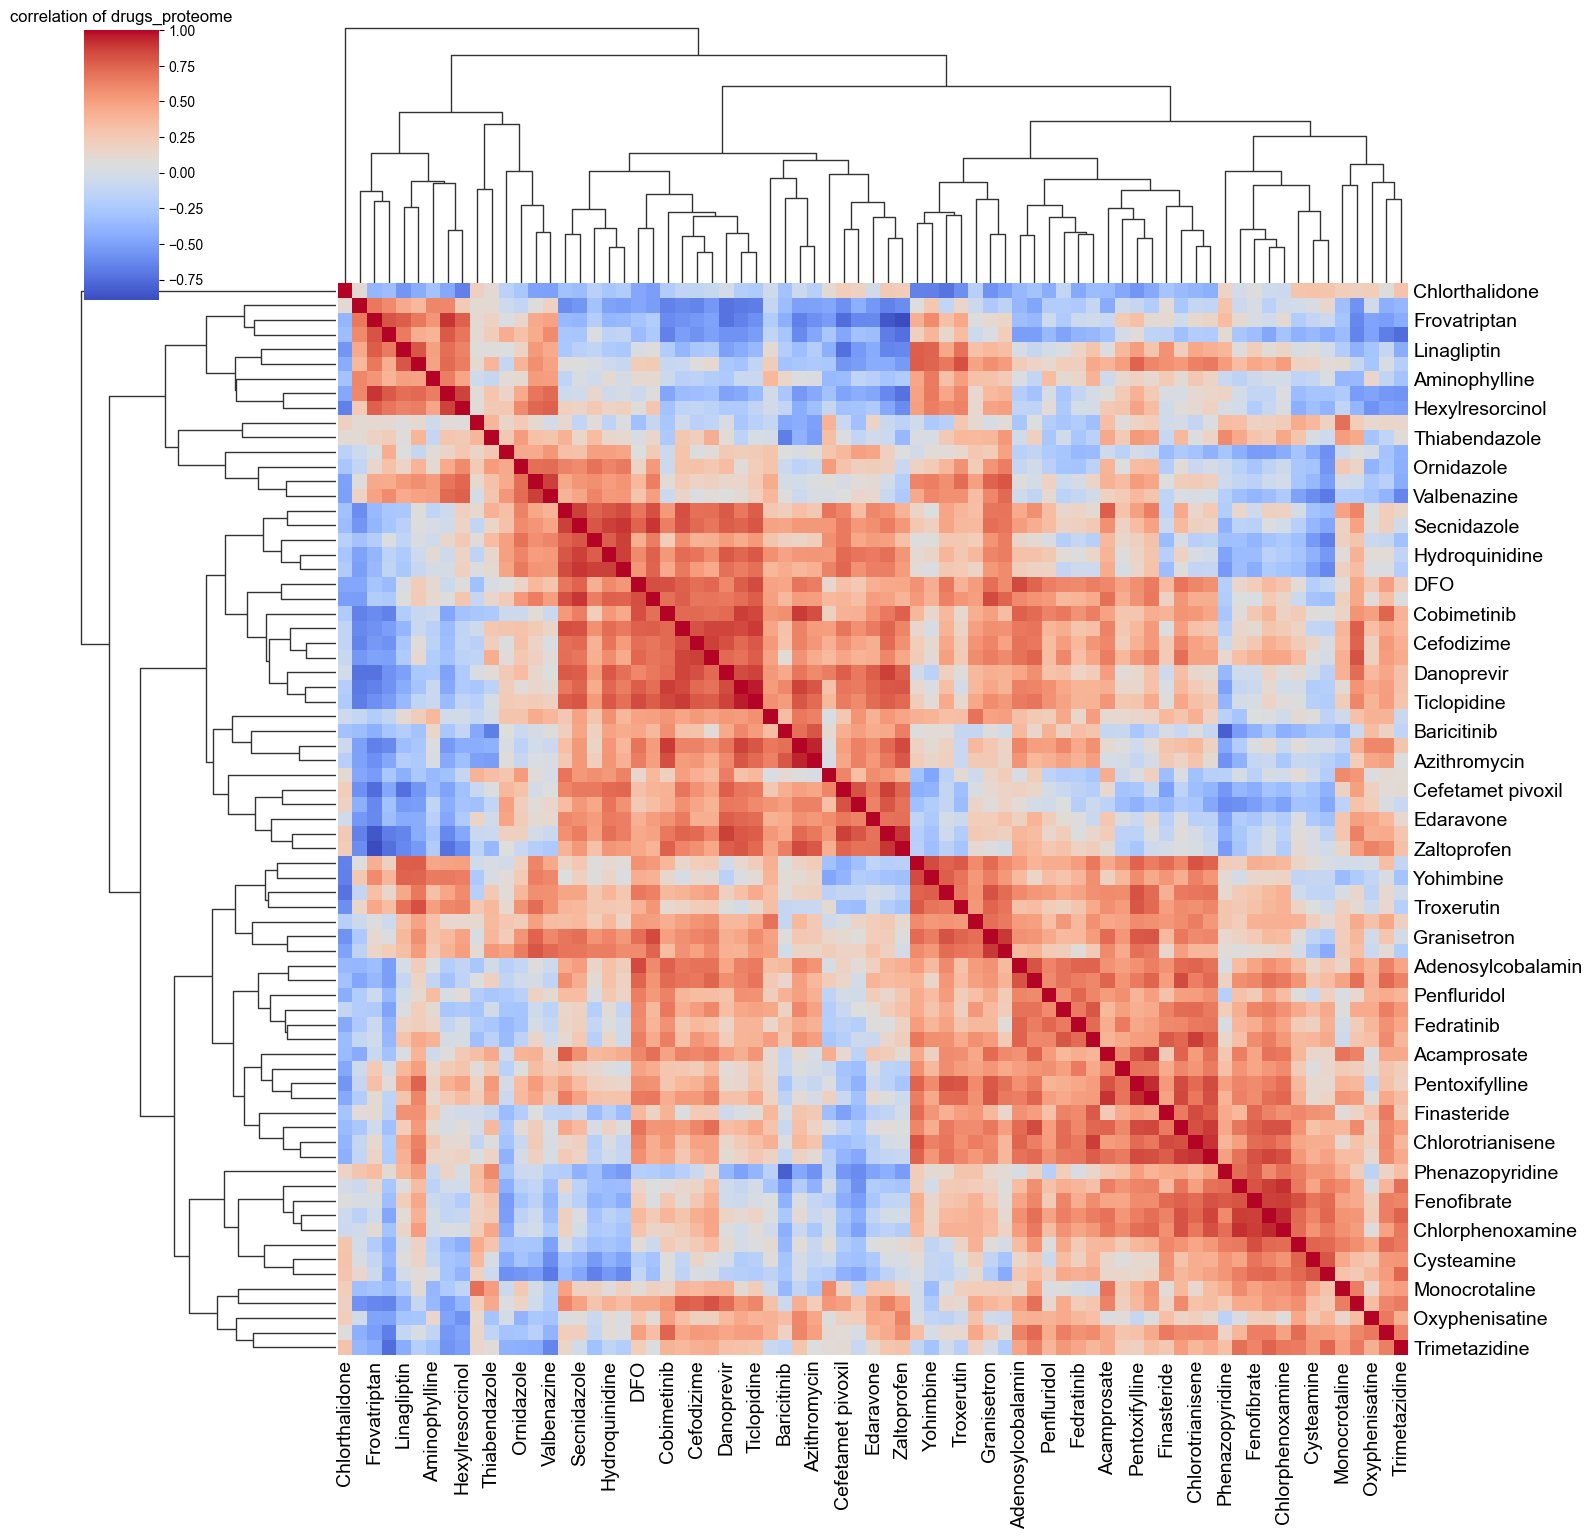

In [188]:

ax = sns.clustermap(correlation_df, cmap='coolwarm', fmt='.2f', figsize=(15,15),
                        row_cluster=True,  # Enable row clustering
                        col_cluster=True,  # Enable column clustering
                        tree_kws={'linewidths': 1}) 
  
ax.ax_heatmap.set_yticklabels(ax.ax_heatmap.get_yticklabels(),fontsize=14)

ax.ax_heatmap.set_xticklabels(ax.ax_heatmap.get_xticklabels(), fontsize=14)
ax.ax_heatmap.tick_params(axis='both', which='both', length=0)
plt.title("correlation of drugs_proteome")
plt.show()

#  pathway analysis starts here

In [195]:
df_mean

,DMSO,DFO,Acamprosate,Acenocoumarol,Adenosylcobalamin,Aminophylline,Asenapine,Azithromycin,Baricitinib,Benzbromarone,...,Thymopentin,Ticlopidine,Triclosan,Trimetazidine,Trimethoprim,Troxerutin,Valbenazine,Vinpocetine,Yohimbine,Zaltoprofen
TRYP,113.674683,111.153127,123.434376,121.815916,108.513730,130.352130,118.237002,112.007453,112.415510,125.125122,...,110.158665,124.129840,121.040557,121.643861,107.854257,113.396629,128.648254,121.444179,121.922673,106.332016
ALBU,108.541145,123.608921,116.196928,105.900223,111.062660,106.578867,100.339535,116.699163,131.410379,100.580398,...,102.104919,111.686062,91.305503,105.297674,91.088729,105.553390,104.925959,87.667559,106.634865,113.401768
FBLL1,7.247863,6.582013,6.803865,6.704248,6.436271,5.473695,6.239044,5.772135,7.054964,5.716271,...,6.693817,6.949078,7.097454,7.326204,6.992089,5.652687,6.707097,6.574022,8.183572,5.476336
DX39A,18.420391,19.992050,17.525744,18.090782,18.118425,18.021617,17.271818,17.432565,18.092474,18.301553,...,18.149247,18.184382,18.231084,17.017845,18.221593,17.949473,18.586309,18.132953,18.206507,20.099514
BACH,2.430539,2.098179,2.299894,2.482245,2.332024,2.378238,2.341961,2.441333,2.330300,2.274119,...,2.431359,2.300778,2.383223,2.366840,2.207827,2.440437,2.493323,2.379541,2.365461,2.369959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SUMO4,7.590512,7.605399,7.846611,7.419124,7.937821,7.177469,7.904727,7.702777,7.561104,7.160397,...,7.203861,7.793575,7.905655,7.672353,7.506768,7.456785,7.369209,7.599602,7.735903,7.590526
SRSF6,27.354004,22.454652,24.947514,26.344801,25.669309,24.449822,26.699888,27.925088,26.731600,26.857424,...,25.614595,25.927268,26.002752,27.902687,28.472441,23.263342,25.394947,26.933898,27.571432,25.142351
SEP11,3.912753,3.856409,3.810272,3.660224,3.913301,3.665484,3.940240,4.105200,3.969733,3.847505,...,3.912254,3.861722,3.680025,3.676818,3.941595,3.711026,3.616446,3.831845,3.613175,3.751166
HBG2,14.496026,15.475686,16.022454,13.172319,13.393556,12.553775,13.009897,15.466949,15.063115,14.760085,...,14.353191,12.890623,12.256286,12.840831,10.991639,12.557887,14.448167,12.490779,13.464253,15.918992


In [196]:
scaled_df2

,DFO,Acamprosate,Acenocoumarol,Adenosylcobalamin,Aminophylline,Asenapine,Azithromycin,Baricitinib,Benzbromarone,Benzoin,...,Thymopentin,Ticlopidine,Triclosan,Trimetazidine,Trimethoprim,Troxerutin,Valbenazine,Vinpocetine,Yohimbine,Zaltoprofen
TRYP,-0.629098,0.624163,0.459005,-0.898440,1.330097,0.093788,-0.541917,-0.500276,0.796698,0.161386,...,-0.730580,0.695133,0.379882,0.441447,-0.965737,-0.400156,1.156222,0.421070,0.469899,-1.121076
ALBU,1.560063,0.941379,0.081906,0.512818,0.138553,-0.382248,0.983301,2.211256,-0.362143,0.556543,...,-0.234890,0.564854,-1.136325,0.031611,-1.154419,0.052956,0.000584,-1.439986,0.143227,0.708065
FBLL1,-0.052639,0.245700,0.111738,-0.248629,-1.543070,-0.513853,-1.141738,0.583370,-1.216862,-0.334584,...,0.097710,0.440978,0.640509,0.948123,0.498817,-1.302367,0.115570,-0.063386,2.101086,-1.539518
DX39A,2.986600,-1.024791,-0.105770,-0.060809,-0.218265,-1.437797,-1.176346,-0.103018,0.237045,0.611651,...,-0.010678,0.046468,0.122428,-1.850879,0.106991,-0.335606,0.700193,-0.037180,0.082453,3.161389
BACH,-3.164628,-0.923974,1.101587,-0.567072,-0.053726,-0.456690,0.647133,-0.586218,-1.210282,-0.257289,...,0.536342,-0.914152,0.001647,-0.180334,-1.946652,0.637187,1.224638,-0.039251,-0.195647,-0.145682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SUMO4,0.139270,0.883156,-0.435191,1.164443,-1.180443,1.062382,0.439580,0.002667,-1.233094,0.871436,...,-1.099053,0.719595,1.065244,0.345754,-0.164903,-0.319048,-0.589128,0.121393,0.541737,0.093402
SRSF6,-2.291159,-0.726550,0.150437,-0.273526,-1.038919,0.373302,1.142281,0.393206,0.472177,0.258343,...,-0.307866,-0.111621,-0.064245,1.128222,1.485820,-1.783597,-0.445726,0.520175,0.920315,-0.604263
SEP11,-0.140664,-0.417983,-1.319875,0.201295,-1.288257,0.363219,1.354738,0.540491,-0.194186,0.457809,...,0.194999,-0.108732,-1.200854,-1.220134,0.371361,-1.014519,-1.583011,-0.288311,-1.602668,-0.773247
HBG2,1.015484,1.391986,-0.570602,-0.418260,-0.996529,-0.682445,1.009468,0.731390,0.522725,-0.427264,...,0.242540,-0.764577,-1.201378,-0.798863,-2.072207,-0.993697,0.307940,-1.039907,-0.369578,1.320742


In [197]:
import gseapy as gp

In [198]:
enr_pro = gp.enrichr(gene_list= df_mean.index[2:].tolist(), 
                 gene_sets='KEGG_2021_Human', 
                 organism='Human',  
                 outdir='enrichr_results'  
                )

In [199]:
pathway_pro = enr_pro.results

In [200]:
tt = pathway_pro.iloc[:15,:]

In [201]:
tt['Genes'] = tt['Genes'].apply(lambda x: x.split(';'))
tt

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,Spliceosome,32/150,2.973977e-12,7.048325e-10,0,0,5.232956,138.888507,"[DDX5, RBM25, SF3B2, SF3B3, RBM8A, DDX46, SF3B..."
1,KEGG_2021_Human,DNA replication,9/36,5.639712e-05,6.683059e-03,0,0,6.314685,61.777150,"[RFC5, FEN1, PCNA, MCM7, MCM3, MCM4, MCM5, MCM..."
2,KEGG_2021_Human,Non-homologous end-joining,5/13,2.977996e-04,2.352617e-02,0,0,11.804726,95.843631,"[FEN1, XRCC6, MRE11, PRKDC, XRCC5]"
3,KEGG_2021_Human,Pentose phosphate pathway,7/30,6.004109e-04,3.557434e-02,0,0,5.755299,42.692214,"[PRPS2, PRPS1, G6PD, ALDOC, ALDOA, TKT, PGM1]"
4,KEGG_2021_Human,RNA transport,20/186,1.191635e-03,5.648352e-02,0,0,2.290860,15.423054,"[RBM8A, FUS, FMR1, SUMO4, FXR2, XPO1, XPOT, EI..."
5,KEGG_2021_Human,Proteasome,8/46,1.939740e-03,7.661974e-02,0,0,3.981931,24.867959,"[PSMD8, PSMD7, PSMD4, PSMD2, PSME3, PSMD3, PSM..."
6,KEGG_2021_Human,Glycolysis / Gluconeogenesis,8/67,1.920536e-02,6.502387e-01,0,0,2.561792,10.125650,"[LDHB, LDHA, ALDH2, PGAM1, PGK1, ALDOC, ALDOA,..."
7,KEGG_2021_Human,Base excision repair,5/33,2.381156e-02,7.054174e-01,0,0,3.369225,12.592763,"[FEN1, PCNA, PARP1, APEX1, HMGB1]"
8,KEGG_2021_Human,Parkinson disease,19/249,4.858413e-02,9.999960e-01,0,0,1.563813,4.729689,"[TRAP1, PARK7, COX5B, SDHA, SDHB, PSMD8, UCHL1..."
9,KEGG_2021_Human,Cell cycle,11/124,4.918992e-02,9.999960e-01,0,0,1.839423,5.540466,"[HDAC2, PCNA, MCM7, PRKDC, CDK1, MCM3, MCM4, M..."


In [202]:
df_expression = scaled_df2
df_pathways = tt

df_result = pd.DataFrame(columns=df_expression.columns)

for i, row in tt.iterrows():
    pathway_genes = row['Genes']
    df_genes = df_expression.loc[pathway_genes]
    df_sum = df_genes.sum()
    df_result.loc[row['Term']] = df_sum

df_result

,DFO,Acamprosate,Acenocoumarol,Adenosylcobalamin,Aminophylline,Asenapine,Azithromycin,Baricitinib,Benzbromarone,Benzoin,...,Thymopentin,Ticlopidine,Triclosan,Trimetazidine,Trimethoprim,Troxerutin,Valbenazine,Vinpocetine,Yohimbine,Zaltoprofen
Spliceosome,24.971537,-4.273314,-3.733638,4.868731,-12.301688,14.026094,7.089945,2.506952,-13.983307,-5.089636,...,-3.610135,3.829875,-6.317726,-4.735521,13.909436,-3.896609,7.816282,-6.493754,7.131238,2.989125
DNA replication,-6.350567,-5.282694,-1.620189,-3.644018,2.680469,-0.562306,-2.262143,-6.985107,-5.665098,-4.444804,...,1.106591,-4.634385,-5.744381,-4.153106,2.607590,9.198133,2.019473,-2.203866,3.718102,6.597754
Non-homologous end-joining,1.406139,-2.630551,2.343197,0.712347,-1.499221,-1.666155,0.625872,-2.932576,-1.725722,-3.000073,...,-0.831344,-3.601080,-0.252303,0.038323,0.593343,1.841098,-0.445113,-5.278574,0.349784,-0.583320
Pentose phosphate pathway,3.722518,0.021529,1.330498,-0.800712,-4.744146,-0.280516,6.278369,1.866869,-1.099504,-1.702577,...,-1.588051,0.037138,-1.019279,-2.550429,2.584505,-1.139062,-0.911413,0.497526,-1.476785,-0.057948
RNA transport,11.872244,-7.147863,-3.836329,-2.505597,-9.675780,8.295722,-2.154704,1.553664,-16.303747,-2.960968,...,-8.481797,-2.533108,3.239908,-4.292311,-0.790000,3.364038,3.874901,-1.984445,-1.409430,-4.978956
Proteasome,-4.886414,-4.865996,3.437275,-1.336907,0.154685,-1.654077,0.268308,-0.572915,-2.308330,-5.263311,...,3.396655,-2.230333,-0.862986,-7.201981,-9.308487,1.513123,2.813116,4.041456,3.926815,7.762591
Glycolysis / Gluconeogenesis,3.204274,-1.001347,-2.594493,-2.897417,-1.969162,4.981454,-0.836898,-4.247249,-6.214520,-0.125183,...,0.657217,0.151403,-2.828789,-3.233880,5.304752,5.571844,0.496977,1.217400,3.802773,0.143783
Base excision repair,2.611694,1.402835,1.186041,4.770788,-2.619596,0.418941,-1.153923,-0.100732,-4.347662,-0.282915,...,-1.881363,-4.636997,-2.607202,-0.943616,2.621613,3.370732,-2.098975,-0.786007,0.954410,0.254933
Parkinson disease,0.034721,-9.364476,2.975062,-1.207031,-4.420370,7.423324,0.207068,-6.615226,-8.674345,-4.909583,...,1.939233,-0.186465,-1.503201,-7.266596,-2.588355,-1.758733,-2.020143,1.840694,3.169239,4.064846
Cell cycle,-6.495347,-6.745177,-4.571519,-5.038548,4.047194,2.110223,-0.080261,-5.829601,-8.404273,-1.447510,...,0.783003,-3.645119,-3.509428,-4.644197,-1.203939,9.502515,2.731246,-0.840033,5.071729,2.974320


In [207]:
def plot_clusterheatmap2(dfheatmap, low=-2, high=2):
    # Define custom color map
    colors = ["#437EB8", "#8EBBE7", "#D8E2EB", "white", "#D8E2EB", "#EB6CB6", "#E72998"]
    n_bins = 10  # Number of bins in the color map
    cmap_name = "custom_diverging"
    custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
#     custom_cmap = "viridis"
    # Create the heatmap with the custom color map
    plt.rcParams['font.family'] = 'Arial'
        # Create the heatmap with the custom color map, figure size, and hidden dendrograms
    ax = sns.clustermap(dfheatmap, annot=False, cmap=custom_cmap, cbar=True, vmin=low, vmax=high,
                        figsize=(21, 9),  # Set the figure size here
                        row_cluster=True,  # Enable row clustering
                        col_cluster=True,  # Enable column clustering
                        dendrogram_ratio=(.001, .001),  # Minimize the dendrogram size
                        tree_kws={'linewidths': 0}, # Make dendrogram lines invisible
                        cbar_pos=(-0.05, 0.76, 0.025, 0.20))
    # Customize the color bar ticks and labels
    cbar = ax.ax_heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize = 20) 
#     if ax.cax is not None:
#         ax.cax.set_visible(False)
#     ax.ax_heatmap.set_xlabel('Regulation Type', fontsize=14)
#     ax.ax_heatmap.set_ylabel('Drug Candidates', fontsize=14)
#     ax.ax_heatmap.set_xticklabels([])
    ax.ax_heatmap.set_xticklabels(ax.ax_heatmap.get_xticklabels(), rotation=90, fontsize=16)  # Customize x-tick labels
    ax.ax_heatmap.set_yticklabels(ax.ax_heatmap.get_yticklabels(), fontsize=20)  # Customize y-tick labels
    ax.ax_heatmap.tick_params(axis='x', which='both', length=0)
#     plt.xlabel('Regulation Type', fontsize=10)
#     plt.ylabel('Drug Candidates', fontsize=10)
#     plt.xticks([])  # Ensure all x-tick labels are shown
#     plt.yticks(fontsize=10)
#     # Save or display the plot
    # plt.savefig(f'{figure_save_path}/_clustered_heatmap.svg', dpi=800, bbox_inches='tight')
    plt.show()

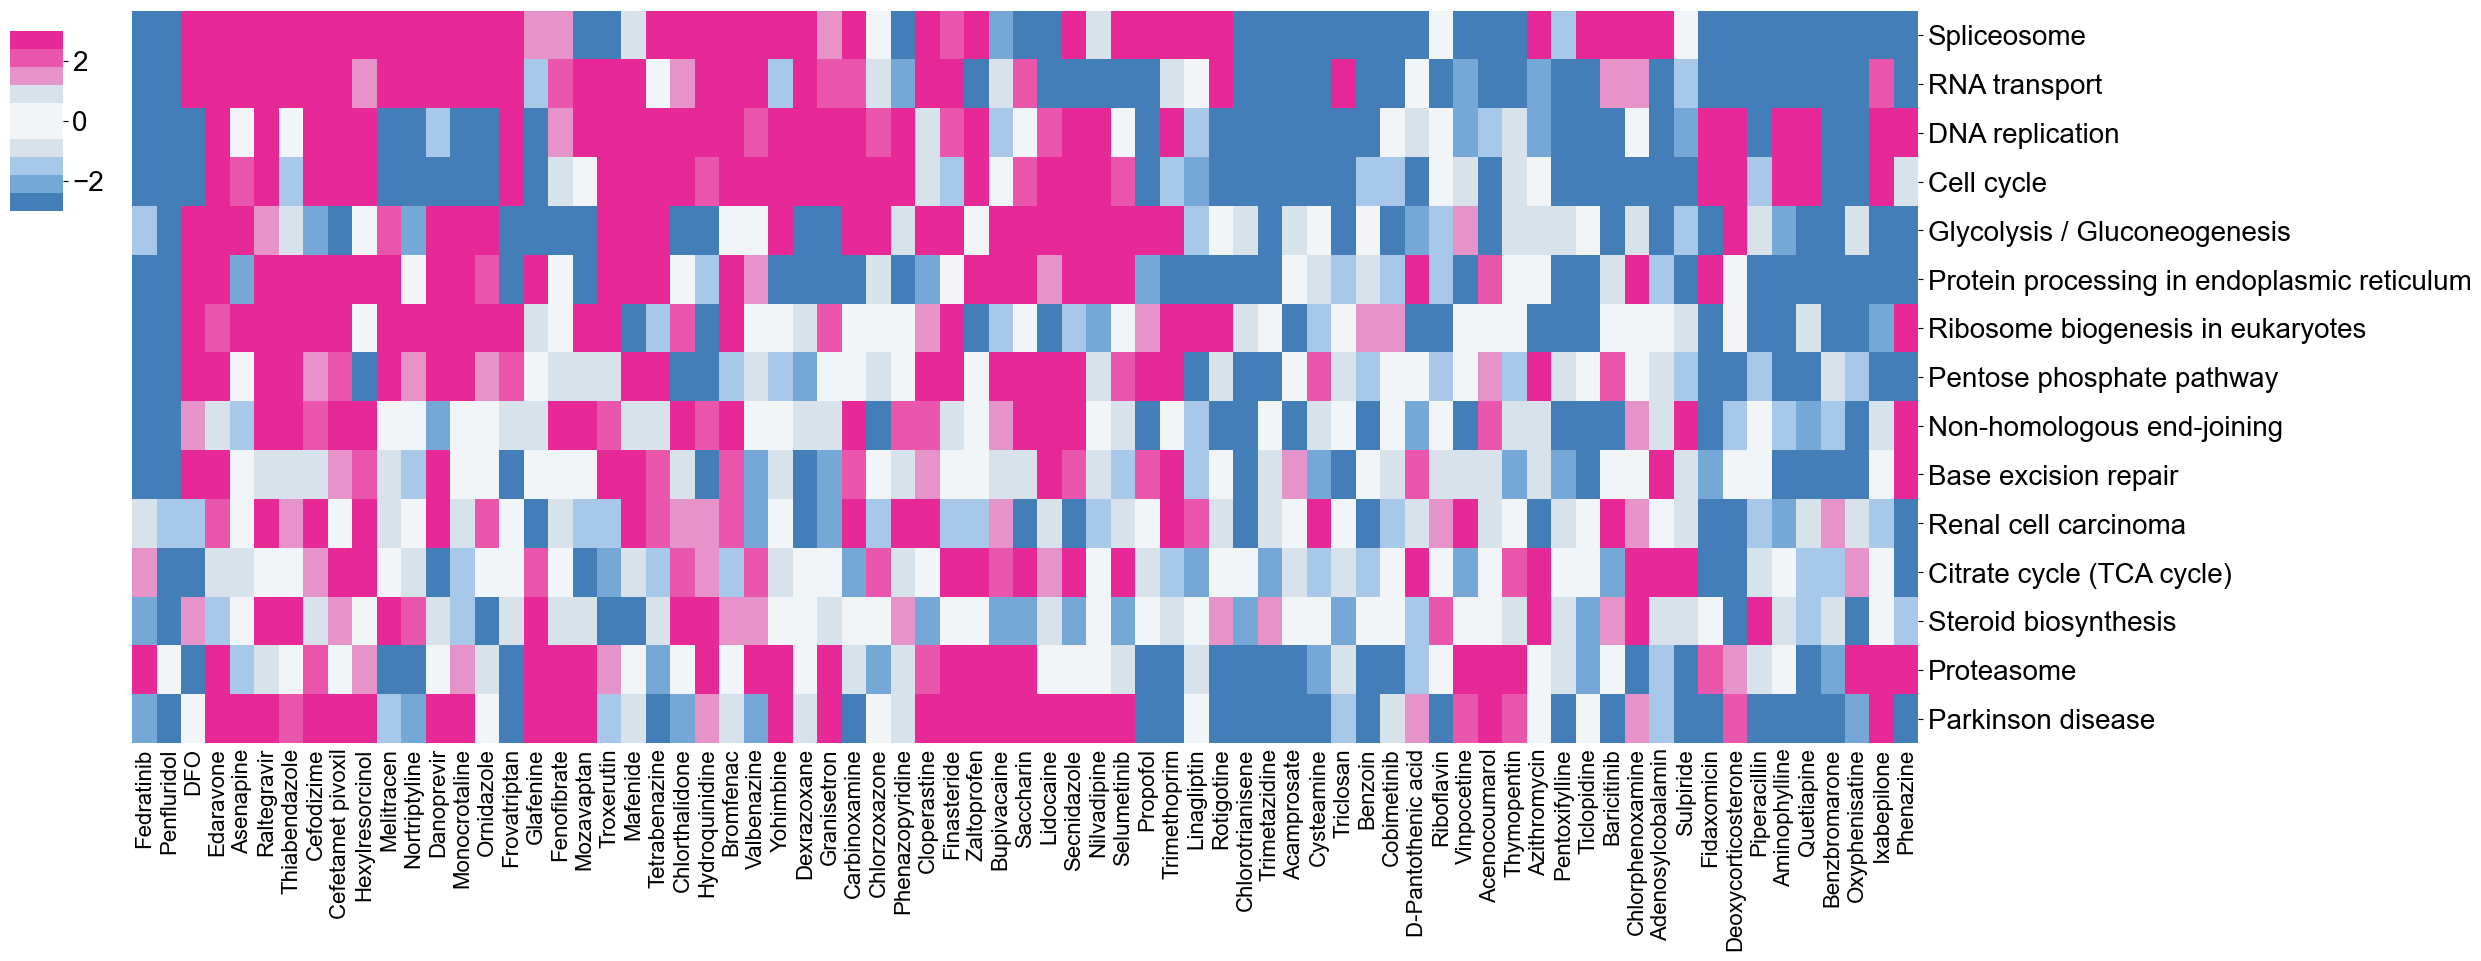

In [208]:
plot_clusterheatmap2(df_result, low=-3, high=3)

In [157]:
import pandas as pd
import plotly.graph_objects as go

# 假设 df_pathways 的结构如下：
df_pathways = tt

# 将基因列分割成单个基

# 获取所有通路和基因的名称
all_genes = [gene for genes in df_pathways['Genes'] for gene in genes]
all_pathways = df_pathways['Term'].tolist()

# 创建Sankey图的节点（通路和基因）
nodes = list(set(all_genes + all_pathways))
node_dict = {name: i for i, name in enumerate(nodes)}

# 创建Sankey图的链接（通路到基因）
sources = []
targets = []
values = []

for i, row in df_pathways.iterrows():
    for gene in row['Genes']:
        sources.append(node_dict[row['Term']])
        targets.append(node_dict[gene])
        values.append(1)  # 每个基因和通路的关系可以设为 1

# 创建Sankey图
fig = go.Figure(go.Sankey(
    node=dict(
        pad=3,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=nodes,

        customdata=nodes,  # 这里可以自定义节点的元数据
    ),
    link=dict(
        source=sources,  # 起点节点
        target=targets,  # 终点节点
        value=values,    # 值
    )
))

fig.update_layout(title_text="Gene to Pathway Mapping - Alluvial Diagram", font_size=10)
fig.show()
